# Protocol for Bone Analysis Workflow

## 0. Import Libraries and Parameters Setting

In [1]:
# Standard Libraries
import os
import math
import pickle
from collections import defaultdict
from datetime import datetime
import re
from itertools import islice

# Numerical and Data Manipulation
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image

# Spatial Analysis and Geometry
from scipy.spatial import KDTree, ConvexHull
from scipy.spatial.distance import pdist, squareform, jensenshannon
from shapely.geometry import Polygon, box
import geopandas as gpd

# Image Processing
from skimage import measure, morphology
from scipy.ndimage import gaussian_filter1d

# Interpolation and Optimization
from scipy.interpolate import Rbf, griddata
from scipy.optimize import minimize

# Statistical Analysis
from scipy.stats import gaussian_kde, entropy, mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Clustering and Dimensionality Reduction
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_score,
    recall_score, f1_score, accuracy_score, balanced_accuracy_score
)

# File and Data Formats
from imaris_ims_file_reader.ims import ims

In [2]:
os.getcwd()
os.chdir('/Users/fm07-admin/Projects/DisVis/')
# Increase the maximum image size limit
Image.MAX_IMAGE_PIXELS = None
data_dir_5fu = 'data_metabone_5fu'
save_dir = 'results_metabone_5fu'
os.makedirs(save_dir, exist_ok=True)

mk_color_map = {
    'MKs': "#FF00FF",  # Magenta 
    'Adipos': "#C96500",  # Brown 
    'Sinusoids': "#00FFFF",  # Cyan # Marker CD105 = Sinusoids
    'MSCs': '#FFCC00',  # Yellow # Marker Cxcl12 = MSCs
    'Neurons': "#FF7F00",  # Orange  TODO: the value is not defined 
    'Arteries': "#33A02C", # Green
    #'GFP': "#A6CEE3", # Light Blue
    'Bones': "#A6CEE3" # Light Blue
}


hscs_color_map = {
    'HSCs': "#A6CEE3" ,  # Light Blue
    'RDs' : "#A9A9A9" # Gray
}

condition_colors = {
    'd0': '#E31A1C',  # Red
    'd5': '#FF1493',  # Deep Pink
    'd10': '#4B0082', # Indigo
    'd15': '#20B2AA', # Light Sea Green
    'd30': '#FFD700',  # Gold
    'd60': '#8A2BE2',  # Blue Violet
    'd15_Detex': '#008080'  # Teal '#FF4500'  # Orange Red '#808080'  # Grey 
}

cluster_colors = {
    1: "#B15928",  # Brown
    2: "#6A3D9A",  # Purple
    3: "#FF7F00",  # Orange
    4: "#FDBF6F",  # Light Orange
    5: "#A6CEE3",  # Light Blue
    6: "#FB9A99",  # Pink
    7: "#CAB2D6",  # Lavender
    8: "#1F78B4",  # Blue
    9: "#B2DF8A",  # Light Green
    10: "#33A02C"  # Green
}

## 1. Data Import



### 1.1 Load CSV Files

In [10]:
# Define a function to filter and get the Position.csv files by condition
# TODO: adjust code so it can get the files by the number of the subdirectory automatically
def get_position_files_by_conditions(data_dir=data_dir_5fu):
    # Lists to store Position.csv files for each condition
    position_files_d5 = []
    position_files_d10 = []
    position_files_d15 = []
    position_files_d30 = []
    position_files_d60 = []
    position_files_ss = []
    
    # Find all directories in data_dir_5fu, excluding .ims files
    all_dirs = [os.path.join(data_dir_5fu, d) for d in os.listdir(data_dir_5fu) if d.startswith('d')] # get all the directories starting with 2
    
    # Classify the directories into d5, d10, d15, d30, or "ss"
    for data_dir in all_dirs:
        
        sub_dirs = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('Statistics')]
        for sub_dir in sub_dirs:
            # Get the first file ending with 'Position.csv' in each sub-directory
            # First check for Position_Reference_Frame.csv, if not found, fallback to Position.csv
            position_file = [os.path.join(sub_dir, f) for f in os.listdir(sub_dir) if f.endswith('Position_Reference_Frame.csv')]
            if not position_file:
                # Only look for Position.csv if Position_Reference_Frame.csv is not found
                position_file = [os.path.join(sub_dir, f) for f in os.listdir(sub_dir) if f.endswith('Position.csv')]
        
            if position_file:
                if 'd5' in data_dir:
                    position_files_d5.append(position_file[0])
                elif 'd10' in data_dir:
                    position_files_d10.append(position_file[0])
                elif 'd15' in data_dir:
                    position_files_d15.append(position_file[0])
                elif 'd30' in data_dir:
                    position_files_d30.append(position_file[0])
                elif 'd60' in data_dir:
                    position_files_d60.append(position_file[0])
                else:
                    # Files that don't contain 'd5', 'd10', 'd15', or 'd30' are classified as "ss"
                    position_files_ss.append(position_file[0])

    # Return a dictionary with the results
    return {
        'd5': position_files_d5,
        'd10': position_files_d10,
        'd15': position_files_d15,
        'd30': position_files_d30,
        'd60': position_files_d60,
        'ss': position_files_ss
    }

# Get position files for d5, d10, d15, d30, and the "ss" case
position_files_by_conditions = get_position_files_by_conditions()
# position_files_by_conditions_hsc = get_position_files_by_conditions_hsc()

# Access individual lists for each condition
position_dirs_d5 = position_files_by_conditions['d5']
position_dirs_d10 = position_files_by_conditions['d10']
position_dirs_d15 = position_files_by_conditions['d15']
position_dirs_d30 = position_files_by_conditions['d30'] 
position_dirs_d60 = position_files_by_conditions['d60']
position_dirs_ss = position_files_by_conditions['ss']


In [4]:
# Read the position files and create the DataFrames with columns 'Position.x', 'Position.y', 'Position.z'
# Regular expression to capture the word that starts with 'm' and extract the part after 'm'
pattern = r'\bm([A-Za-z0-9]+)'

def process_position_dirs(position_dirs, scale_factors):
    """
    Process a list of CSV files containing position data, scales the coordinates,
    and stores the resulting DataFrame in the provided output dictionary.
    
    Parameters:
    position_dirs (list): List of file paths to CSV files containing the position data.
    scale_factors (dict): Dictionary with scaling factors for 'x', 'y', and 'z'.
                        e.g., {'x': 0.7575, 'y': 0.7575, 'z': 2.5}
    Returns:
    None: The function modifies the provided output_dict in place.
    """
    output_dict = {}
    for position_dir in position_dirs:
        # print(position_dir.split('/')[-1])
        df = pd.read_csv(position_dir, skiprows=3)
        
        # Take the first 3 columns as the position coordinates
        df = df.iloc[:, :3]
        df.columns = ['Position.X', 'Position.Y', 'Position.Z']
        
        # Scale the position coordinates
        df['Position.X'] = df['Position.X'] / scale_factors['x']
        df['Position.Y'] = df['Position.Y'] / scale_factors['y']
        df['Position.Z'] = df['Position.Z'] / scale_factors['z']
        
        # Extract a key name for the output dictionary from the file path
        if 'CD105' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'Sinusoids'])
            print(df_name)
        elif 'Sinusoids' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'Sinusoids'])
            print(df_name)
        elif 'Cxcl12' in position_dir and 'acatCxcl12' not in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'MSCs'])
            print(df_name)
        elif 'MSCs' in position_dir and 'acatCxcl12' not in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'MSCs'])
            print(df_name)
        elif 'HSC' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'HSCs'])
            print(df_name)
            # df_name = position_dir.split('/')[-1].split('.')[0]
        elif 'RD' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'RDs'])
            print(df_name)
        elif 'Sca1' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'Arteries'])
            print(df_name)
        elif 'Arteries' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'Arteries'])
            print(df_name)
        elif 'GFAP' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'Neurons'])
            print(df_name)
        elif 'MK' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'MKs'])
            print(df_name)
        elif 'Adipo' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'Adipos'])
            print(df_name)
        elif 'Neurons' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'Neurons'])
            print(df_name)
        elif 'Bone' or 'bone' in position_dir:
            df_name_prefix = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            df_name = '_'.join([df_name_prefix, 'Bones'])
            print(df_name)
        else:
            df_name = '_'.join(position_dir.split('/')[-1].split(' ')[:2])
            print('speical case')
            print(position_dir)
            print(df_name)
        
        # Store the processed DataFrame in the output dictionary
        output_dict[df_name] = df
        
        # Print summary statistics of the DataFrame
        # print(df.describe())
    return output_dict


# Define the scale factors
scale_factors = {'x': 0.7575, 'y': 0.7575, 'z': 2.5}

# Call the function for position_dirs_200901KK_st1 and position_dirs_201002KK_st3
positions_ss = process_position_dirs(position_dirs_ss, scale_factors)
positions_d5 = process_position_dirs(position_dirs_d5, scale_factors)
positions_d10 = process_position_dirs(position_dirs_d10, scale_factors)
positions_d15 = process_position_dirs(position_dirs_d15, scale_factors)
positions_d30 = process_position_dirs(position_dirs_d30, scale_factors)
positions_d60 = process_position_dirs(position_dirs_d60, scale_factors)

210518KK_st10_HSCs
200901KK_st1_HSCs
201002KK_st5_MSCs
200901KK_st3_RDs
201002KK_st5_Bones
200901KK_st1_Neurons
200901KK_st3_HSCs
210518KK_st10_Arteries
210518KKiJHa_st11_RDs
201002KK_st5_RDs
200901KK_st2_RDs
201002KK_st5_Sinusoids
200901KK_st1_MKs
210518KK_st12_RDs
200901KK_st2_MKs
200901KK_st2_Neurons
200901KK_st2_Adipos
200901KK_st2_HSCs
210518KK_st1_RDs
210518KKiJHa_st11_HSCs
210518KK_st12_HSCs
200901KK_st1_RDs
200728KK_st2_HSCs
201002KK_st5_HSCs
210518KK_st1_HSCs
210518KK_st10_RDs
200728KK_st2_RDs
200901KK_st1_Adipos
200110KK_st12_HSCs
200110KK_st12_RDs
200117KKiaJHa_st2_RDs
200117KK_st3_HSCs
200117KK_st5_RDs
191202KK_st4_HSCs
200117KK_st6_RDs
200117KK_st6_MSCs
200117KK_st3_RDs
200117KK_st6_Bones
200110KK_st10_Arteries
200117KK_st3_MKs
200117KK_st4_RDs
200117KK_st5_HSCs
191202KK_st4_RDs
200117KK_st1_RDs
200117KK_st3_Neurons
200117KK_st6_Sinusoids
200117KK_st4_HSCs
200117KKiaJHa_st2_HSCs
200117KK_st6_HSCs
200117KK_st3_Adipos
200117KK_st1_HSCs
200110KK_st3_RDs
191202KK_st3_HSCs
2001

### 1.2 Load Image Files (ims)


In [12]:

# Get the GFP images of the bones
def get_ims_files_by_conditions(data_dir=data_dir_5fu):
    # Lists to store .ims files for each condition
    ims_files_d5 = []
    ims_files_d10 = []
    ims_files_d15 = []
    ims_files_d30 = []
    ims_files_d60 = []
    ims_files_ss = []
    
    # Find all directories in data_dir_5fu, excluding .ims files
    all_dirs = [os.path.join(data_dir_5fu, d) for d in os.listdir(data_dir_5fu) if d.startswith('d')] 
    
    # Classify the directories into d5, d10, d15, d30, or "ss"
    for data_dir in all_dirs:
        sub_dirs = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('ims') and 'GFP' in f]
        if 'd5' in data_dir:
            ims_files_d5.extend(sub_dirs)
        elif 'd10' in data_dir:
            ims_files_d10.extend(sub_dirs)
        elif 'd15' in data_dir:
            ims_files_d15.extend(sub_dirs)
        elif 'd30' in data_dir:
            ims_files_d30.extend(sub_dirs)
        elif 'd60' in data_dir:
            ims_files_d60.extend(sub_dirs)
        else:
            # Files that don't contain 'd5', 'd10', 'd15', or 'd30' are classified as "ss"
            ims_files_ss.extend(sub_dirs)

    # Return a dictionary with the results
    return {
        'd5': ims_files_d5,
        'd10': ims_files_d10,
        'd15': ims_files_d15,
        'd30': ims_files_d30,
        'd60': ims_files_d60,
        'ss': ims_files_ss
    }


# Filter the ims files, keep the one with shorter name
def filter_ims_files(ims_list):
    # Dictionary to hold the shortest file for each unique prefix
    grouped_files = defaultdict(list)

    # Group filenames by the unique prefix after `d0/`
    for filepath in ims_list:
        # Extract the unique prefix (first two elements after 'd0/')
        parts = filepath.split('/')
        if len(parts) >= 3:
            unique_prefix = parts[2].split()[0] + ' ' + parts[2].split()[1]  # Example: '200901KK st1'
            grouped_files[unique_prefix].append(filepath)

    # Filter to keep only the shortest name in each group
    filtered_bone_ims = []
    for prefix, files in grouped_files.items():
        # Sort by filename length and take the shortest
        shortest_file = min(files, key=len)
        filtered_bone_ims.append(shortest_file)
    return filtered_bone_ims
        



# Convert the bone images with non-zero values to dataframes with Position.X and Position.Y columns
def image_to_df(image):
    # Find the non-zero intensities and their coordinates
    non_zero_coords = np.nonzero(image)  # Returns the y, x coordinates where intensity > 0
    # intensity_values = image[non_zero_coords]  # Extract the intensity values

    # Create a DataFrame from the non-zero coordinates and intensity values
    df = pd.DataFrame({
        'source': 'GFP',
        'Position.Z': 0, #non_zero_coords[0],
        'Position.Y': non_zero_coords[0],
        'Position.X': non_zero_coords[1]
    })
    
    return df




# Function to process and store images for a given condition
def process_bone_images(bone_ims_files):
    bone_dict = {}
    
    for i in bone_ims_files:
        # Extract bone name from the file path
        bone_name = '_'.join(i.split('/')[-1].split(' ')[:2])
        
        # Load and process the image (assuming ims function is defined elsewhere)
        bone_img = ims(i)  # You need to ensure that ims(i) correctly loads the image
        # bone_img = bone_img[0, bone_img.shape[1] - 1, :, :, :].max(axis=0).copy()
        bone_img = bone_img[0, 0, :, :, :].max(axis=0).copy()
        # Morphological operations, labeling and remove small objects
        # Threshold the image to create a binary mask
        binary_img = bone_img > 0
        # Label the binary image
        labeled_img = measure.label(binary_img)
        # Remove small objects
        # TODO: we need to try out the min_size
        cleaned_img = morphology.remove_small_objects(labeled_img, min_size=10000)
        # Convert the cleaned image back to binary
        bone_img_df = image_to_df(cleaned_img)
        # Store the processed image in the dictionary with the extracted name
        bone_dict[bone_name] = bone_img_df

    return bone_dict




In [ ]:
# Access individual lists for each condition
ims_files_by_conditions = get_ims_files_by_conditions()
bone_ss_ims = ims_files_by_conditions['ss']
bone_d5_ims = ims_files_by_conditions['d5']
bone_d10_ims = ims_files_by_conditions['d10']
bone_d15_ims = ims_files_by_conditions['d15']
bone_d30_ims = ims_files_by_conditions['d30']
bone_d60_ims = ims_files_by_conditions['d60']

# Filter the ims files, keep the one with shorter name
filtered_bone_ss_ims = filter_ims_files(bone_ss_ims)
filtered_bone_d5_ims = filter_ims_files(bone_d5_ims)
filtered_bone_d10_ims = filter_ims_files(bone_d10_ims)
filtered_bone_d15_ims = filter_ims_files(bone_d15_ims)
filtered_bone_d30_ims = filter_ims_files(bone_d30_ims)
filtered_bone_d60_ims = filter_ims_files(bone_d60_ims)

# Process images for each condition
bone_ss = process_bone_images(filtered_bone_ss_ims)
bone_d5 = process_bone_images(filtered_bone_d5_ims)
bone_d10 = process_bone_images(filtered_bone_d10_ims)
bone_d15 = process_bone_images(filtered_bone_d15_ims)
bone_d30 = process_bone_images(filtered_bone_d30_ims)
bone_d60 = process_bone_images(filtered_bone_d60_ims)


"\n# Access individual lists for each condition\nims_files_by_conditions = get_ims_files_by_conditions()\nbone_ss_ims = ims_files_by_conditions['ss']\nbone_d5_ims = ims_files_by_conditions['d5']\nbone_d10_ims = ims_files_by_conditions['d10']\nbone_d15_ims = ims_files_by_conditions['d15']\nbone_d30_ims = ims_files_by_conditions['d30']\nbone_d60_ims = ims_files_by_conditions['d60']\n\n# Filter the ims files, keep the one with shorter name\nfiltered_bone_ss_ims = filter_ims_files(bone_ss_ims)\nfiltered_bone_d5_ims = filter_ims_files(bone_d5_ims)\nfiltered_bone_d10_ims = filter_ims_files(bone_d10_ims)\nfiltered_bone_d15_ims = filter_ims_files(bone_d15_ims)\nfiltered_bone_d30_ims = filter_ims_files(bone_d30_ims)\nfiltered_bone_d60_ims = filter_ims_files(bone_d60_ims)\n\n# Process images for each condition\nbone_ss = process_bone_images(filtered_bone_ss_ims)\nbone_d5 = process_bone_images(filtered_bone_d5_ims)\nbone_d10 = process_bone_images(filtered_bone_d10_ims)\nbone_d15 = process_bone_im

### 1.3 Convert Image to Dataframe and Combine both Dataframes

In [7]:
# From the positions_ss, positions_d5, positions_d10, positions_d15, positions_d30
def positions_concat(positions_dict, bone_dict):
    positions_df_dict = dict()
    keys = {}
    
    # Create a mapping of dataset and sources
    for key in positions_dict.keys():
        dataset = '_'.join(key.split('_')[:2])
        source = key.split('_')[-1]
        if dataset not in keys:
            keys[dataset] = [source]
        else:
            keys[dataset].append(source)
    
    # Concatenate DataFrames, adding a 'source' column
    for dataset, sources in keys.items():
        df = pd.concat(
            [positions_dict[f'{dataset}_{source}'].assign(source=source) for source in sources], 
            ignore_index=True
        )
        df = pd.concat([df, bone_dict[dataset]], ignore_index=True)
        positions_df_dict[dataset] = df
    return positions_df_dict

# positions_ss_dfs = positions_concat(positions_ss, bone_ss)
# positions_d5_dfs = positions_concat(positions_d5, bone_d5)
# positions_d10_dfs = positions_concat(positions_d10, bone_d10)
positions_d15_dfs = positions_concat(positions_d15, bone_d15)
# positions_d30_dfs = positions_concat(positions_d30, bone_d30)
positions_d60_dfs = positions_concat(positions_d60, bone_d60)

In [ ]:
# delete bone_ss, bone_d5, bone_d10, bone_d15, bone_d30 to free up memory
del bone_ss, bone_d5, bone_d10, bone_d15, bone_d30, bone_d60

### 1.4 Load Inhibitor Data

In [13]:
data_dir_inhibitor_Detex = 'data_metabone_inhibitors/metabone Detex inhibitor data'

position_files_inhibitor_Detex = get_position_files_by_conditions(data_dir=data_dir_inhibitor_Detex)

position_dirs_inhibitor_Detex_d15 = position_files_inhibitor_Detex['d15']

ims_files_inhibitor_Detex = get_ims_files_by_conditions(data_dir=data_dir_inhibitor_Detex)
bone_d15_inhibitor_Detex = process_bone_images(filter_ims_files(ims_files_inhibitor_Detex['d15']))

# Call the function for position_dirs_200901KK_st1 and position_dirs_201002KK_st3
positions_d15_inhibitor_Detex = process_position_dirs(position_dirs_inhibitor_Detex_d15, scale_factors)

positions_d15_inhibitor_Detex_dfs = positions_concat(positions_d15_inhibitor_Detex, bone_d15_inhibitor_Detex)
# delete bone_d15_inhibitor_GW, bone_d15_inhibitor_Detex to free up memory
del bone_d15_inhibitor_Detex


Opening readonly file: data_metabone_5fu/d15/200901KK st5 5FU d15 mGFP vol HSC iso RD iso.ims 

Closing file: data_metabone_5fu/d15/200901KK st5 5FU d15 mGFP vol HSC iso RD iso.ims 

Opening readonly file: data_metabone_5fu/d15/200908KK st4 5FU d15 GFP volume.ims 

Closing file: data_metabone_5fu/d15/200908KK st4 5FU d15 GFP volume.ims 

Opening readonly file: data_metabone_5fu/d15/240819JH st2 5FU d15 GFP volume.ims 

Closing file: data_metabone_5fu/d15/240819JH st2 5FU d15 GFP volume.ims 

Opening readonly file: data_metabone_5fu/d15/210108KK st10 acat20b 5FU d15 mGFP mSca1 Sca1 iso split objects.ims 

Closing file: data_metabone_5fu/d15/210108KK st10 acat20b 5FU d15 mGFP mSca1 Sca1 iso split objects.ims 

Opening readonly file: data_metabone_5fu/d15/200728KK st3 acat15 5FU d15 mGFP vol HSC iso RD iso.ims 

Closing file: data_metabone_5fu/d15/200728KK st3 acat15 5FU d15 mGFP vol HSC iso RD iso.ims 

Opening readonly file: data_metabone_5fu/d15/201020KK st1 acatCxcl1227a d15 mGFP vol 

### 1.5 Load Reference Bone

In [14]:
reference_bone_dir = 'data_metabone_5fu/reference_bone/200117KK st4 acat27a 5FU d5 mBone(1)  mGFP(2).ims'
reference_bone = ims(reference_bone_dir)

# ref_bone_outer = reference_bone[0,0,:,:,:].max(axis=0).copy()
ref_bone_inner = reference_bone[0,1,:,:,:].max(axis=0).copy()

# ref_bone_outer = image_to_df(ref_bone_outer)
ref_bone_inner = image_to_df(ref_bone_inner)

# Flip the y-axis to match the image coordinates
# y_max = np.max((ref_bone_outer['Position.Y'].max(), ref_bone_inner['Position.Y'].max()))
y_max = ref_bone_inner['Position.Y'].max()
# ref_bone_outer['Position.Y'] = y_max - ref_bone_outer['Position.Y']
ref_bone_inner['Position.Y'] = y_max - ref_bone_inner['Position.Y']

# delete reference bone to save memory
del reference_bone

Opening readonly file: data_metabone_5fu/reference_bone/200117KK st4 acat27a 5FU d5 mBone(1)  mGFP(2).ims 

Closing file: data_metabone_5fu/reference_bone/200117KK st4 acat27a 5FU d5 mBone(1)  mGFP(2).ims 



## 2. Data Inspection and Adjustments

### 2.1 Visual Inspection

In [21]:
positions_d60_dfs['240129JH_st8'].source.unique()

array(['Adipos', 'Sinusoids', 'HSCs', 'Bones', 'Neurons', 'RDs', 'MKs',
       'Arteries', 'GFP'], dtype=object)

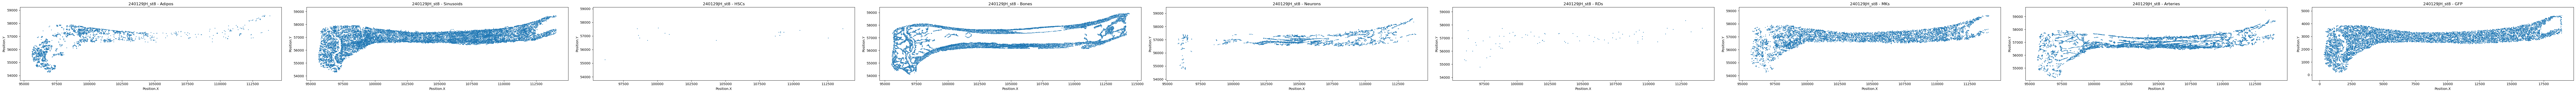

In [25]:
# Visualize the x, y for each df 
# for test_df in [positions_ss_dfs, positions_d5_dfs, positions_d10_dfs, positions_d15_dfs, positions_d30_dfs]:
for test_df in[positions_d60_dfs]:
    fig, axs = plt.subplots(len(test_df.keys()), 9, figsize=(12*9, 4*len(test_df.keys())))

    # Visualize the steady state positions row by key and the columns are source
    for i, key in enumerate(test_df.keys()):
        for j, source in enumerate(test_df[key]['source'].unique()):
            if source == 'GFP':
                sample_number = 10000
                source_df = test_df[key].loc[test_df[key]['source'] == source, ['Position.X', 'Position.Y']].sample(sample_number)
            else:
                source_df = test_df[key].loc[test_df[key]['source'] == source, ['Position.X', 'Position.Y']]
            # ax = axs[i, j]
            ax = axs[j]
            ax.scatter(source_df['Position.X'], source_df['Position.Y'], s=1)
            ax.set_title(f"{key} - {source}")
            ax.axis('equal')
            ax.set_xlabel('Position.X')
            ax.set_ylabel('Position.Y')
            
    plt.tight_layout()
    # fig.savefig(f'{save_dir}/{datetime.today().strftime("%y%m%d")}_YL_raw_d5_d10_d15_d30.png')
    plt.show()


### 2.2 Data Adjustments (Flipping Coordinates, etc.)

In [ ]:
# Based on the visual check above, we need to flip the y axis for dataset with key 
# ss: '201002KK_st5'
# d5: '200117KK_st3', 
# d10: '200110KK_st3', 
# d15: '200908KK_st4', '240819JH_st2'
# The flip should be applied to all sources but the shift should only based on the MK source
def y_flip(positions_df_dict, keys_to_flip):
    for key in keys_to_flip:
        # y_min = positions_df_dict[key]['Position.Y'].min()
        y_max = positions_df_dict[key]['Position.Y'].max()
        # Flip the y axis, we don't care about the source
        positions_df_dict[key]['Position.Y'] = y_max - positions_df_dict[key]['Position.Y']
    return positions_df_dict

positions_ss_dfs = y_flip(positions_ss_dfs, ['201002KK_st5', '200901KK_st3', '210518KK_st12', '210518KK_st1', '200728KK_st2'])
positions_d5_dfs = y_flip(positions_d5_dfs, ['200117KK_st3', '200117KK_st5', '200117KK_st4','200117KK_st1'])
positions_d10_dfs = y_flip(positions_d10_dfs, ['200110KK_st3','200110KK_st1', '191202KK_st1', '200110KK_st4', '200110KK_st8'])
positions_d15_dfs = y_flip(positions_d15_dfs, ['240819JH_st2', '201002KK_st7', '201020KK_st1', '200901KK_st5', '200728KK_st3', '200908KK_st4', '210108KK_st10'])
positions_d30_dfs = y_flip(positions_d30_dfs, ['200901KK_st7', '201103KKI_st4', '201103KK_st2', '200908KK_st2', '240926JH_st2'])


def x_flip(positions_df_dict, keys_to_flip):
    for key in keys_to_flip:
        # x_min = positions_df_dict[key]['Position.X'].min()
        x_max = positions_df_dict[key]['Position.X'].max()
        # Flip the x axis, we don't care about the source
        positions_df_dict[key]['Position.X'] = x_max - positions_df_dict[key]['Position.X']
    return positions_df_dict

positions_d5_dfs = x_flip(positions_d5_dfs, ['200117KK_st5'])


In [ ]:
positions_d15_inhibitor_Detex_dfs = y_flip(positions_d15_inhibitor_Detex_dfs, ['201209KK_st4', '201121KK_st4'])

In [ ]:
# Visualize the x, y for each df again after flipping the coordinates
for test_df in [positions_ss_dfs, positions_d5_dfs, positions_d10_dfs, positions_d15_dfs, positions_d30_dfs]:
    fig, axs = plt.subplots(len(test_df.keys()), 7, figsize=(12*len(test_df.keys()), 36))

    # Visualize the steady state positions row by key and the columns are source
    for i, key in enumerate(test_df.keys()):
        for j, source in enumerate(test_df[key]['source'].unique()):
            if source == 'GFP':
                sample_number = 10000
                source_df = test_df[key].loc[test_df[key]['source'] == source, ['Position.X', 'Position.Y']].sample(sample_number)
            else:
                source_df = test_df[key].loc[test_df[key]['source'] == source, ['Position.X', 'Position.Y']]
            ax = axs[i, j]
            ax.scatter(source_df['Position.X'], source_df['Position.Y'], s=1)
            ax.set_title(f"{key} - {source}")
            ax.axis('equal')
            ax.set_xlabel('Position.X')
            ax.set_ylabel('Position.Y')
            
    plt.tight_layout()
    # fig.savefig(f'{save_dir}/{datetime.today().strftime("%y%m%d")}_YL_raw_d5_d10_d15_d30.png')
    plt.show()


## 3. Bone Alignment and Transformation

### 3.1 Align Bones to the Reference Bone

In [ ]:
# Find the 2D outline of the bone in the x-y plane
def find_outline(points, window_size=10):
    """
    Find the outline of a set of points by finding the min and max y-values for each x-value within a window.
    The outline is only in the x-y plane.
    Parameters:
    points : np.array of shape (n,2) points.
    window_size : size of the window to smooth the outline.
    Returns:
    outline_points : np.array of outline points.
    """
    df = pd.DataFrame(points, columns=['x', 'y'])
    
    min_y_points = []
    max_y_points = []

    # Sort points by x value
    df_sorted = df.sort_values(by='x')
    
    # Slide over the x values with a window
    for i in range(0, len(df_sorted), window_size):
        window = df_sorted.iloc[i:i + window_size]
        min_y = window.loc[window['y'].idxmin()]
        max_y = window.loc[window['y'].idxmax()]
        min_y_points.append(min_y)
        max_y_points.append(max_y)
    
    # Ensure the outline is in order
    min_y_points = pd.DataFrame(min_y_points).drop_duplicates().sort_values(by='x').values
    max_y_points = pd.DataFrame(max_y_points).drop_duplicates().sort_values(by='x', ascending=False).values

    # Combine min_y and max_y points and close the loop
    outline_points = np.vstack([min_y_points, max_y_points, min_y_points[0]])

    return outline_points

# 0. Calculate the overlap
# 1. Find the outline of each bone based on the x-y plane

# 2. Find the center of each bone (outline) and put the center of the bones at the same position
def calculate_centroid(outline_points):
    """
    Calculate the centroid of the bone outline.
    
    Parameters:
    outline_points : np.array of shape (n, 2)
    
    Returns:
    centroid : tuple containing (centroid_x, centroid_y)
    """
    # Use the weight centroid
    centroid_x = np.mean(outline_points[:, 0])
    centroid_y = np.mean(outline_points[:, 1])
    
    # Using the middle of the x and y values as the centroid
    # x_min, x_max = outline_points[:, 0].min(), outline_points[:, 0].max()
    # y_min, y_max = outline_points[:, 1].min(), outline_points[:, 1].max()
    # centroid_x = (x_min + x_max) / 2
    # centroid_y = (y_min + y_max) / 2
    return centroid_x, centroid_y
def translate_to_origin(outline_points, centroid):
    """
    Translate the outline points so that the centroid is at the origin.
    
    Parameters:
    outline_points : np.array of shape (n, 2)
    centroid : tuple containing (centroid_x, centroid_y)
    
    Returns:
    translated_points : np.array of shape (n, 2)
    """
    translated_points = outline_points.astype(np.float64).copy()
    
    translated_points[:, 0] -= centroid[0]
    translated_points[:, 1] -= centroid[1]
    return translated_points
# 3. Rescale the bones to the same size (bounding box)(optional)
def get_max_dimensions(bone_dicts):
    """
    Find the maximum width and height across all bone outlines in the given dictionaries.
    
    Parameters:
    bone_dicts : list of dictionaries of bones (where each value is a DataFrame with 'Position.X' and 'Position.Y')
    
    Returns:
    max_width : float, maximum width found across all bones
    max_height : float, maximum height found across all bones
    """
    max_width = 0
    max_height = 0
    
    for bone_dict in bone_dicts:
        for df in bone_dict.values():
            # Extract bone points where 'source' == 'Bone'
            bone_points = df[df['source'] == 'Bone'][['Position.X', 'Position.Y']].values
            
            # Find min and max values of x and y
            min_x, max_x = bone_points[:, 0].min(), bone_points[:, 0].max()
            min_y, max_y = bone_points[:, 1].min(), bone_points[:, 1].max()
            
            # Calculate width and height
            width = max_x - min_x
            height = max_y - min_y
            
            # Update maximum width and height if necessary
            if width > max_width:
                max_width = width
            if height > max_height:
                max_height = height
                
    return max_width, max_height
def rescale_outline(outline_points, max_width, max_height):
    """
    Rescale the bone outline to fit within the maximum width and height across all bones.
    
    Parameters:
    outline_points : np.array of shape (n, 2)
    max_width : float, the maximum width across all bones
    max_height : float, the maximum height across all bones
    
    Returns:
    scaled_points : np.array of shape (n, 2)
    """
    min_x, max_x = outline_points[:, 0].min(), outline_points[:, 0].max()
    min_y, max_y = outline_points[:, 1].min(), outline_points[:, 1].max()

    current_width = max_x - min_x
    current_height = max_y - min_y

    scale_x = max_width / current_width
    scale_y = max_height / current_height

    scaled_points = outline_points.copy()
    scaled_points[:, 0] *= scale_x
    scaled_points[:, 1] *= scale_y

    return scaled_points

# Calculate the overlap area on the grid inside the outline
def calculate_overlap_area(reference_outline, target_outline, resolution=200):
    """
    Calculate the overlap area (in terms of pixels or points) between two outlines.
    
    Parameters:
    reference_outline : np.array of shape (n, 2), outline of the reference bone
    target_outline : np.array of shape (n, 2), outline of the target bone
    resolution : int, the number of points or pixels to use for the area calculation.
    
    Returns:
    overlap_area : float, the number of pixels or points where the areas overlap.
    """
    # Ensure the outlines are 2D arrays of shape (N, 2)
    reference_outline = np.asarray(reference_outline).reshape(-1, 2)
    target_outline = np.asarray(target_outline).reshape(-1, 2)
    
    # Calculate centroids for both bones
    reference_centroid = calculate_centroid(reference_outline)
    target_centroid = calculate_centroid(target_outline)
    
    # Translate both bones to center them
    reference_outline_centered = translate_to_origin(reference_outline, reference_centroid)
    target_outline_centered = translate_to_origin(target_outline, target_centroid)
    
    # Get bounding box of the reference outline
    min_x, max_x = reference_outline_centered[:, 0].min(), reference_outline_centered[:, 0].max()
    min_y, max_y = reference_outline_centered[:, 1].min(), reference_outline_centered[:, 1].max()
    
    # Generate grid of points (pixels) covering the bounding box
    x_grid = np.linspace(min_x, max_x, resolution)
    y_grid = np.linspace(min_y, max_y, resolution)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

    # Create Path objects for the reference and target outlines
    reference_path = Path(reference_outline_centered)
    target_path = Path(target_outline_centered)
    
    # Check which points of the grid are inside both outlines
    points_in_reference = reference_path.contains_points(grid_points)
    points_in_target = target_path.contains_points(grid_points)
    
    # Calculate the overlap area as the number of points (pixels) inside both outlines
    overlap_area = np.sum(points_in_reference & points_in_target)
    
    return overlap_area

def rotate_points(points, angle):
    """
    Rotate a set of points by a given angle.
    
    Parameters:
    points : np.array of shape (n, 2)
    angle : float, angle to rotate by in radians
    
    Returns:
    rotated_points : np.array of shape (n, 2)
    """
    # Ensure points are a 2D array of shape (N, 2)
    points = np.asarray(points).reshape(-1, 2)
    
    # Rotation matrix
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], 
                                [np.sin(angle), np.cos(angle)]])
    
    # Rotate points
    rotated_points = points.dot(rotation_matrix)
    
    return rotated_points

# TODO: for some reason the function seems only test on the initial guesses, so now we are using the grid search
def optimize_rotation(reference_outline, target_outline):
    """
    Optimize the rotation of the target bone to maximize overlap with the reference bone,
    constrained to -90 to 90 degrees.
    
    Parameters:
    reference_outline : np.array of shape (n, 2), outline of the reference bone
    target_outline : np.array of shape (n, 2), outline of the target bone
    
    Returns:
    optimal_rotated_points : np.array of shape (n, 2), the rotated and recentered target bone outline with maximum overlap
    optimal_angle : float, the optimal rotation angle in radians
    """
    
    def objective_function(angle):
        # Rotate the target outline by the current angle
        rotated_outline = rotate_points(target_outline, angle)
        # Calculate the negative overlap (since we are minimizing)
        return -calculate_overlap_area(reference_outline, rotated_outline)

    # Try different initial guesses for the angle to improve convergence
    initial_guesses = [-0.1, 0, 0.1]  # You can try different values here
    
    best_result = None
    best_angle = None
    best_rotated_points = None

    for x0 in initial_guesses:
        # Perform optimization with the initial guess x0
        result = minimize(objective_function, x0=x0, bounds=[(-np.pi/4, np.pi/4)], method='L-BFGS-B', options={'maxiter': 50})
        
        # Check if this result is valid and better than the current best
        if result.success:
            if best_result is None or result.fun < best_result:
                best_result = result.fun
                best_angle = result.x[0]
                best_rotated_points = rotate_points(target_outline, best_angle)

    if best_rotated_points is None:
        raise ValueError("Optimization failed to converge.")

    # Recenter the final rotated outline
    final_centroid = calculate_centroid(best_rotated_points)
    best_rotated_points = translate_to_origin(best_rotated_points, final_centroid)
    
    return best_rotated_points, best_angle, final_centroid

def grid_search_rotation(reference_outline, target_outline, angle_step=np.pi/36):
    """
    Perform a grid search over possible rotation angles to maximize overlap.
    
    Parameters:
    reference_outline : np.array of shape (n, 2), outline of the reference bone
    target_outline : np.array of shape (n, 2), outline of the target bone
    angle_step : float, step size for angle search (in radians)
    
    Returns:
    best_rotated_points : np.array of shape (n, 2), the rotated target bone outline with maximum overlap
    best_angle : float, the optimal rotation angle in radians
    """
    best_angle = None
    max_overlap = -np.inf
    best_rotated_points = None
    
    # Iterate over angles between -90 and 90 degrees (in radians)
    for angle in np.arange(-np.pi/4, np.pi/4, angle_step):
        rotated_outline = rotate_points(target_outline, angle)
        overlap = calculate_overlap_area(reference_outline, rotated_outline)
        
        if overlap > max_overlap:
            max_overlap = overlap
            best_angle = angle
            best_rotated_points = rotated_outline
    
    # Recenter the final rotated outline
    final_centroid = calculate_centroid(best_rotated_points)
    best_rotated_points = translate_to_origin(best_rotated_points, final_centroid)
    
    return best_rotated_points, best_angle, final_centroid

# Modify the process_and_align_bones function to accept the max_width and max_height
def process_and_align_bones_with_overlap(bone_dict, reference_bone_name='201002KK_st5', window_size=500):
    """
    Process and align all bones from the given dictionary to maximize overlap with a reference bone.
    
    Parameters:
    bone_dict : dict of bones, where each value is a DataFrame with 'Position.X' and 'Position.Y'.
    reference_bone_name : string, the name of the bone to use as the reference for alignment.
    
    Returns:
    aligned_bones : dict of aligned bone outlines
    """
    aligned_bones = {}
    aligned_angles = {}
    aligned_centroids = {}
    # Check the type of the reference_bone_name
    # If it is a dataframe, we can use the reference_bone_name directly
    if isinstance(reference_bone_name, pd.DataFrame):
        reference_df = reference_bone_name
        reference_points = reference_df[reference_df['source'] == 'GFP'][['Position.X', 'Position.Y']].values
        reference_outline = find_outline(reference_points, window_size=window_size)
        reference_centroid = calculate_centroid(reference_outline)
        reference_outline = translate_to_origin(reference_outline, reference_centroid)
        
        for bone_name, df in bone_dict.items():

            # Filter points where 'source' == 'Bone'
            bone_points = df[df['source'] == 'GFP'][['Position.X', 'Position.Y']].values
        
            # Find the outline of the target bone
            target_outline = find_outline(bone_points, window_size=window_size)
            # Optimize rotation to maximize overlap with the reference bone
            aligned_outline, best_angle, final_centroid = grid_search_rotation(reference_outline, target_outline)
            aligned_bones[bone_name] = aligned_outline
            aligned_angles[bone_name] = best_angle
            aligned_centroids[bone_name] = final_centroid

        
    elif isinstance(reference_bone_name, str):
            
        
        # Extract the reference bone outline
        reference_df = positions_ss_dfs[reference_bone_name]
        reference_points = reference_df[reference_df['source'] == 'Bone'][['Position.X', 'Position.Y']].values

        reference_outline = find_outline(reference_points, window_size=window_size)
        # Recenter the reference outline
        reference_centroid = calculate_centroid(reference_outline)
        reference_outline = translate_to_origin(reference_outline, reference_centroid)
        
        for bone_name, df in bone_dict.items():

            if bone_name == reference_bone_name:
                # Keep the reference bone as is
                aligned_bones[bone_name] = reference_outline
                aligned_angles[bone_name] = 0
                aligned_centroids[bone_name] = reference_centroid
            else:
                # Filter points where 'source' == 'Bone'
                bone_points = df[df['source'] == 'Bone'][['Position.X', 'Position.Y']].values
            
                # Find the outline of the target bone
                target_outline = find_outline(bone_points, window_size=window_size)
                # Optimize rotation to maximize overlap with the reference bone
                aligned_outline, best_angle, final_centroid = grid_search_rotation(reference_outline, target_outline)
                aligned_bones[bone_name] = aligned_outline
                aligned_angles[bone_name] = best_angle
                aligned_centroids[bone_name] = final_centroid
    
    return aligned_bones, aligned_angles, aligned_centroids


In [ ]:
# Compare the outline found based on the ref_bone_outer and the ref_bone_inner
# recenter and find the outline
# ref_bone_outer_points = ref_bone_outer[ref_bone_outer['source'] == 'GFP'][['Position.X', 'Position.Y']].values
ref_bone_inner_points = ref_bone_inner[ref_bone_inner['source'] == 'GFP'][['Position.X', 'Position.Y']].values

# ef_bone_outer_outline = find_outline(ref_bone_outer_points, window_size=500)
ref_bone_inner_outline = find_outline(ref_bone_inner_points, window_size=500)
# ref_bone_outer_centroid = calculate_centroid(ref_bone_outer_outline)
ref_bone_inner_centroid = calculate_centroid(ref_bone_inner_outline)

# The two shared the same centroid
# ref_bone_outer_outline = translate_to_origin(ref_bone_outer_outline, ref_bone_outer_centroid)
# ref_bone_inner_outline = translate_to_origin(ref_bone_inner_outline, ref_bone_outer_centroid)
ref_bone_inner_outline = translate_to_origin(ref_bone_inner_outline, ref_bone_inner_centroid)

fig, ax = plt.subplots(figsize=(15, 5))
# ax.plot(ref_bone_outer_outline[:, 0], ref_bone_outer_outline[:, 1], color='r', label='Outer')
ax.plot(ref_bone_inner_outline[:, 0], ref_bone_inner_outline[:, 1], color='b', label='Inner')
ax.set_title('Outer and Inner Bone Outlines')

plt.legend()
plt.show()

In [ ]:

# Apply the process to all bone dictionaries using the max width and height
aligned_ss_bone_outlines, aligned_ss_angles, aligned_ss_centroids = process_and_align_bones_with_overlap(positions_ss_dfs, reference_bone_name=ref_bone_inner, window_size=500)
aligned_d5_bone_outlines, aligned_d5_angles, aligned_d5_centroids= process_and_align_bones_with_overlap(positions_d5_dfs, reference_bone_name=ref_bone_inner, window_size=500)
aligned_d10_bone_outlines, aligned_d10_angles, aligned_d10_centroids = process_and_align_bones_with_overlap(positions_d10_dfs, reference_bone_name=ref_bone_inner, window_size=500)
aligned_d15_bone_outlines, aligned_d15_angles, aligned_d15_centroids = process_and_align_bones_with_overlap(positions_d15_dfs, reference_bone_name=ref_bone_inner, window_size=500)
aligned_d30_bone_outlines, aligned_d30_angles, aligned_d30_centroids = process_and_align_bones_with_overlap(positions_d30_dfs, reference_bone_name=ref_bone_inner, window_size=500)

In [ ]:
# Applied the rotation and recenter to all the populations and save the aligned bones

def align_bones_with_centroids_angles(positions_df, aligned_centroids, aligned_angles):
    aligned_bones = {}
    
    for bone_name, df in positions_df.items():
        # Get the centroid of the bone
        centroid = aligned_centroids[bone_name]
        # Get the angle to rotate
        angle = aligned_angles[bone_name]

        # The order of the rotation and the translation matters!
        # The centroids are based on the rotated and translated points
        # Rotate the df
        df_rotated = df.copy()
        # Exclude the Bone points
        # TODO: if we still want to find the combined outline, then we will need to perform the rotation and recentering on the 'Bone' as well
        # df_rotated = df_rotated[df_rotated['source'] != 'Bone']
        df_rotated[['Position.X', 'Position.Y']] = rotate_points(df_rotated[['Position.X', 'Position.Y']].values, angle)
        
        # Translate the df
        df_translated = df_rotated.copy()
        df_translated['Position.X'] -= centroid[0]
        df_translated['Position.Y'] -= centroid[1]
        
        aligned_bones[bone_name] = df_translated
    return aligned_bones


aligned_ss_bones = align_bones_with_centroids_angles(positions_ss_dfs, aligned_ss_centroids, aligned_ss_angles)
aligned_d5_bones = align_bones_with_centroids_angles(positions_d5_dfs, aligned_d5_centroids, aligned_d5_angles)


In [ ]:
# Delete positions_ss_dfs, positions_d5_dfs, positions_d10_dfs, positions_d15_dfs, positions_d30_dfs to save memory
del positions_ss_dfs, positions_d5_dfs

In [ ]:
aligned_d10_bones = align_bones_with_centroids_angles(positions_d10_dfs, aligned_d10_centroids, aligned_d10_angles)
aligned_d15_bones = align_bones_with_centroids_angles(positions_d15_dfs, aligned_d15_centroids, aligned_d15_angles)
aligned_d30_bones = align_bones_with_centroids_angles(positions_d30_dfs, aligned_d30_centroids, aligned_d30_angles)


In [ ]:
del positions_d10_dfs, positions_d15_dfs, positions_d30_dfs

In [ ]:
aligned_d15_bone_outlines_Detex, aligned_d15_angles_Detex, aligned_d15_centroids_Detex = process_and_align_bones_with_overlap(positions_d15_inhibitor_Detex_dfs, reference_bone_name=ref_bone_inner, window_size=500)
aligned_d15_bones_Detex = align_bones_with_centroids_angles(positions_d15_inhibitor_Detex_dfs, aligned_d15_centroids_Detex, aligned_d15_angles_Detex)
del positions_d15_inhibitor_Detex_dfs

In [ ]:
'''
only will be used if we want to compare the aligned data with transformed data
# Concat all the dataframe from aligned_bones
aligned_positions_ss_df = pd.concat(aligned_ss_bones)
aligned_positions_d5_df = pd.concat(aligned_d5_bones)
aligned_positions_d10_df = pd.concat(aligned_d10_bones)
aligned_positions_d15_df = pd.concat(aligned_d15_bones)
aligned_positions_d30_df = pd.concat(aligned_d30_bones)

# Before we save the file, we exclude the data when source is 'Bone'
aligned_positions_ss_df = aligned_positions_ss_df[aligned_positions_ss_df['source'] != 'GFP']
aligned_positions_d5_df = aligned_positions_d5_df[aligned_positions_d5_df['source'] != 'GFP']
aligned_positions_d10_df = aligned_positions_d10_df[aligned_positions_d10_df['source'] != 'GFP']
aligned_positions_d15_df = aligned_positions_d15_df[aligned_positions_d15_df['source'] != 'GFP']
aligned_positions_d30_df = aligned_positions_d30_df[aligned_positions_d30_df['source'] != 'GFP']

# Save the data points 
aligned_positions_ss_df.to_csv(f'{save_dir}/aligned_positions_ss_df.csv', index=False)
aligned_positions_d5_df.to_csv(f'{save_dir}/aligned_positions_d5_df.csv', index=False)
aligned_positions_d10_df.to_csv(f'{save_dir}/aligned_positions_d10_df.csv', index=False)
aligned_positions_d15_df.to_csv(f'{save_dir}/aligned_positions_d15_df.csv', index=False)
aligned_positions_d30_df.to_csv(f'{save_dir}/aligned_positions_d30_df.csv', index=False)
'''

In [ ]:
# Delete positions_ss_dfs, positions_d5_dfs, positions_d10_dfs, positions_d15_dfs, positions_d30_dfs to save memory
# These dataframes are important for the alignment, outline creation
# Of course, we can create the new outline based on the aligned data (dict)
# TODO: delete them after we confirm the outline for each bone
# del positions_ss_dfs, positions_d5_dfs, positions_d10_dfs, positions_d15_dfs, positions_d30_dfs

### 3.2 Transform Bone Coordinates

In [ ]:
# Smooth the outlines
def smooth_outline(outline, sigma=2):
    if not np.array_equal(outline[0], outline[-1]):
        outline = np.vstack([outline, outline[0]])
    smoothed_x = gaussian_filter1d(outline[:, 0], sigma=sigma)
    smoothed_y = gaussian_filter1d(outline[:, 1], sigma=sigma)
    smoothed_outline = np.vstack((smoothed_x, smoothed_y)).T
    if not np.array_equal(smoothed_outline[0], smoothed_outline[-1]):
        smoothed_outline = np.vstack([smoothed_outline, smoothed_outline[0]])
    return smoothed_outline


In [ ]:
# Smooth the reference bone outlines
ref_bone_inner_smoothed = smooth_outline(ref_bone_inner_outline, sigma=80)
common_outline = ref_bone_inner_smoothed

In [ ]:
# Smoothed the alinged_bone_outlines
aligned_ss_bone_outlines_smoothed = {}
aligned_d5_bone_outlines_smoothed = {}
aligned_d10_bone_outlines_smoothed = {}
aligned_d15_bone_outlines_smoothed = {}
aligned_d30_bone_outlines_smoothed = {}
# TODO: problem with the d15 bone outline (because of the discontinious tail)
sigma = 50
for bone_name, outline in aligned_ss_bone_outlines.items():
    smoothed_outline = smooth_outline(outline, sigma=sigma)
    aligned_ss_bone_outlines_smoothed[bone_name] = smoothed_outline
for bone_name, outline in aligned_d5_bone_outlines.items():
    smoothed_outline = smooth_outline(outline, sigma=sigma)
    aligned_d5_bone_outlines_smoothed[bone_name] = smoothed_outline
for bone_name, outline in aligned_d10_bone_outlines.items():
    smoothed_outline = smooth_outline(outline, sigma=sigma)
    aligned_d10_bone_outlines_smoothed[bone_name] = smoothed_outline
for bone_name, outline in aligned_d15_bone_outlines.items():
    smoothed_outline = smooth_outline(outline, sigma=sigma)
    aligned_d15_bone_outlines_smoothed[bone_name] = smoothed_outline
for bone_name, outline in aligned_d30_bone_outlines.items():
    smoothed_outline = smooth_outline(outline, sigma=sigma)
    aligned_d30_bone_outlines_smoothed[bone_name] = smoothed_outline


In [ ]:
# Smooth the aligned bones with inhibitors
aligned_d15_bone_outlines_Detex_smoothed = {}

for bone_name, outline in aligned_d15_bone_outlines_Detex.items():
    smoothed_outline = smooth_outline(outline, sigma=sigma)
    aligned_d15_bone_outlines_Detex_smoothed[bone_name] = smoothed_outline
    

In [ ]:
def get_y_range_at_x(shape_points, x):
    """
    Find the range of y-values where the vertical line at x intersects the shape.
    """
    # Find all edges of the shape where x is between the x-coordinates of the endpoints
    y_vals = []
    for i in range(len(shape_points)):
        p1 = shape_points[i]
        p2 = shape_points[(i + 1) % len(shape_points)]  # wrap around the shape points
        
        # Check if the x value is between p1 and p2's x-coordinates
        if (p1[0] <= x <= p2[0]) or (p2[0] <= x <= p1[0]):
            # Linearly interpolate to find the corresponding y value at x
            if p1[0] != p2[0]:  # Avoid division by zero
                y = p1[1] + (p2[1] - p1[1]) * (x - p1[0]) / (p2[0] - p1[0])
                y_vals.append(y)
    
    if y_vals:
        return min(y_vals), max(y_vals)
    else:
        return None, None  # No intersection with the shape at this x

def create_structured_grid(shape_points, x_num, y_num):
    """
    Create a structured grid by dividing the bounding box of the shape into x_num vertical sections.
    Then place y_num points along each vertical grid line where it intersects the shape.
    """
    shape_points = np.array(shape_points)
    
    # Step 1: Compute the bounding box
    min_x, max_x = np.min(shape_points[:, 0]), np.max(shape_points[:, 0])
    
    # Step 2: Divide the x-range into equal sections
    x_vals = np.linspace(min_x, max_x, x_num + 1)  # x_num divisions create x_num + 1 grid lines
    # Shift the x_vals to the left by half the grid spacing to center the grid
    x_vals = x_vals[1:]  # Remove the first point (left edge of bounding box)
    x_vals = x_vals - (x_vals[1] - x_vals[0]) / 2  # Shift left by half the grid spacing
    
    grid_points = []

    # Step 3: For each x grid line, find the y range and then place points
    for x in x_vals:  # Skip the first and last lines (already have the bounding box)
        y_min, y_max = get_y_range_at_x(shape_points, x)
        
        if y_min is not None and y_max is not None:
            # Get y points by placing y_num points between y_min and y_max
            y_vals = np.linspace(y_min, y_max, y_num+1)
            
            # Shift the y_vals down by half the grid spacing to center the grid
            y_vals = y_vals[1:]  # Remove the first point (bottom edge of bounding box)
            y_vals = y_vals - (y_vals[1] - y_vals[0]) / 2  # Shift down by half the grid spacing
            # Add grid points (x, y) for this vertical line
            for y in y_vals: # Skip the first and last points (already have the y_min and y_max)
                grid_points.append([x, y])

    return np.array(grid_points)

def is_point_inside_shape(point, shape_points):
    """
    Determines if a point is inside an irregular shape using ray-casting.
    """
    x, y = point
    n = len(shape_points)
    inside = False
    p1x, p1y = shape_points[0]
    for i in range(n + 1):
        p2x, p2y = shape_points[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside


def thin_plate_spline_transform(src_points, dst_points):
    """
    Perform Thin Plate Spline (TPS) transformation from src_points to dst_points.
    """
    # Create Radial Basis Function (RBF) interpolators for x and y coordinates
    rbf_x = Rbf(src_points[:, 0], src_points[:, 1], dst_points[:, 0], function='thin_plate')
    rbf_y = Rbf(src_points[:, 0], src_points[:, 1], dst_points[:, 1], function='thin_plate')
    
    def transform(points):
        new_x = rbf_x(points[:, 0], points[:, 1])
        new_y = rbf_y(points[:, 0], points[:, 1])
        return np.vstack([new_x, new_y]).T
    
    return transform

def transform_data(data_points, grid_shape_1, grid_shape_2):
    """
    Apply the TPS transformation to the data points based on the grid transformation.
    """
    # Perform Thin Plate Spline (TPS) transformation
    tps_transform = thin_plate_spline_transform(grid_shape_2, grid_shape_1)
    
    # Apply the transformation to the data points
    transformed_data_points = tps_transform(data_points)
    
    return transformed_data_points


def transform_bone_positions(outline_dict, position_dict, common_outline, x_num=40, y_num=20, source_value=None):
    """
    Transforms the bone positions from multiple datasets using Thin Plate Spline (TPS) based on the provided outlines and positions.
    Parameters:
        outline_dict: Dictionary containing outlines.
        position_dict: Dictionary containing bone positions (DataFrames).
        common_outline: The common outline (to which the other outlines will be aligned).
        x_num: Number of vertical sections for structured grid.
        y_num: Number of horizontal points along each vertical section.
        source_value: If provided, filter the positions based on the specified source value.
    Returns:
        Dictionary containing the transformed bone positions with the 'source' column retained.
    """
    transformed_dict = {}

    # Create the structured grid for the common outline
    grid_common_outline = create_structured_grid(common_outline, x_num=x_num, y_num=y_num)

    # Loop through each dataset in the position_dict
    for dataset_name, position_df in position_dict.items():
        # Get the corresponding outline
        outline_2 = outline_dict[dataset_name]
        
        # Create the structured grid for the specific dataset's outline
        grid_outline_2 = create_structured_grid(outline_2, x_num=x_num, y_num=y_num)

        # Filter the positions based on the source (if provided)
        bone_positions_2, source_column = filter_bone_positions(position_df, source_value=source_value)

        # Transform the filtered bone positions from the dataset outline to the common outline
        transformed_bone_positions = transform_data(bone_positions_2, grid_common_outline, grid_outline_2)

        # Convert the transformed positions to a DataFrame and include the source column
        transformed_df = pd.DataFrame(transformed_bone_positions, columns=['Position.X', 'Position.Y'])
        transformed_df['source'] = source_column  # Add the source column back
        transformed_df['dataset'] = dataset_name  # Add the dataset name column
        # Store the transformed DataFrame in the result dictionary
        transformed_dict[dataset_name] = transformed_df

    return transformed_dict


def filter_bone_positions(df, source_value=None):
    """
    Filters the DataFrame for a specific source if provided and returns the Position.X, Position.Y columns as a NumPy array.
    If source_value is None, return all positions.
    """
    if source_value:
        filtered_df = df[df['source'] == source_value]
    else:
        # Exclude the data with source value 'GFP'
        filtered_df = df[df['source'] != 'GFP']
    positions = filtered_df[['Position.X', 'Position.Y']].to_numpy()
    return positions, filtered_df['source'].to_numpy()  # Return positions and the source column



In [ ]:
x_num = 200
y_num = 35
# 10 mins with 200*35
# We are using the aligned_bone_date dict instead of using the dataframes, because for bones of the same day, they have different bone outline
# Not giving the source value, because we will apply the transformation to all the data without the data with source value 'GFP'
transformed_ss_bones = transform_bone_positions(aligned_ss_bone_outlines_smoothed, aligned_ss_bones, common_outline, x_num=x_num, y_num=y_num)
transformed_d5_bones = transform_bone_positions(aligned_d5_bone_outlines_smoothed, aligned_d5_bones, common_outline, x_num=x_num, y_num=y_num)
transformed_d10_bones = transform_bone_positions(aligned_d10_bone_outlines_smoothed, aligned_d10_bones, common_outline, x_num=x_num, y_num=y_num)
transformed_d15_bones = transform_bone_positions(aligned_d15_bone_outlines_smoothed, aligned_d15_bones, common_outline, x_num=x_num, y_num=y_num)
transformed_d30_bones = transform_bone_positions(aligned_d30_bone_outlines_smoothed, aligned_d30_bones, common_outline, x_num=x_num, y_num=y_num)

# Visualize the original and transformed bone positions for all the data sources
transformed_ss_bones_df = pd.concat(transformed_ss_bones)
transformed_d5_bones_df = pd.concat(transformed_d5_bones)
transformed_d10_bones_df = pd.concat(transformed_d10_bones)
transformed_d15_bones_df = pd.concat(transformed_d15_bones)
transformed_d30_bones_df = pd.concat(transformed_d30_bones)

# 10 mins


In [ ]:
del transformed_ss_bones, transformed_d5_bones, transformed_d10_bones, transformed_d15_bones, transformed_d30_bones

In [ ]:
# Save the transformed bone positions to CSV files
transformed_ss_bones_df.to_csv(f'{save_dir}/transformed_ss_bones_df.csv', index=False)
transformed_d5_bones_df.to_csv(f'{save_dir}/transformed_d5_bones_df.csv', index=False)
transformed_d10_bones_df.to_csv(f'{save_dir}/transformed_d10_bones_df.csv', index=False)
transformed_d15_bones_df.to_csv(f'{save_dir}/transformed_d15_bones_df.csv', index=False)
transformed_d30_bones_df.to_csv(f'{save_dir}/transformed_d30_bones_df.csv', index=False)

In [ ]:
transformed_d15_bones_Detex = transform_bone_positions(aligned_d15_bone_outlines_Detex_smoothed, aligned_d15_bones_Detex, common_outline, x_num=x_num, y_num=y_num)
transformed_d15_bones_Detex_df.to_csv(f'{save_dir}/transformed_d15_bones_Detex_df.csv', index=False)

del transformed_d15_bones_Detex

## 4. Spatial Probability Density Map Generation and Visualization

### 4.1 SPDM Generation (KDE Calculation)

In [ ]:

# Define the function to exclude the data points outside the bone outline
def exclude_outside_bone_outline(df, bone_outline):
    """
    Exclude the data points outside the bone outline using GeoPandas with bounding box filtering for more efficiency.

    Parameters:
    df : DataFrame containing 'Position.X', 'Position.Y', 'weights', and 'source'.
    bone_outline : The outline of the bone to limit the KDE calculation within the bone.

    Returns:
    df_inside : DataFrame containing the data points inside the bone outline.
    """
    # print(df.shape)
    df = pd.DataFrame(df[df['source'] != 'GFP'])
    # print(df.shape)
    # Create a GeoDataFrame from the original DataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Position.X'], df['Position.Y']))

    # Convert the bone outline to a Shapely polygon
    bone_polygon = Polygon(bone_outline)

    # Create a bounding box polygon from the bounds of the bone_polygon
    minx, miny, maxx, maxy = bone_polygon.bounds
    bounding_box = box(minx, miny, maxx, maxy)

    # First, filter by the bounding box of the polygon (faster operation)
    gdf_in_bbox = gdf[gdf.geometry.within(bounding_box)]
    
    # Then, perform the more precise filtering with the actual polygon
    gdf_inside = gdf_in_bbox[gdf_in_bbox.within(bone_polygon)]
    
    # Drop the 'geometry' column if you don't need it in the result
    df_inside = gdf_inside.drop(columns='geometry')

    return df_inside


In [ ]:
# Use the bone outline to generate the KDE for each source
#  Define the KDE function for each source, with weights based on z-aggregated points
def kde_for_source(df, bw_method='scott', bone_outline = None, binsize = 20):
    """
    Apply KDE to estimate the spatial distribution in the x-y plane for each source, 
    with weights aggregated for points with the same x, y but different z.

    Parameters:
    df : DataFrame containing 'Position.X', 'Position.Y', 'weights', and 'source'.
    bw_method : Bandwidth method for KDE (default is 'scott').
    bone_outline : The outline of the bone to limit the KDE calculation within the bone.
    binsize : The size of the bins for the grid used in the KDE calculation.

    Returns:
    kde_result : A dictionary containing the grid and KDE values for each source.
    """
    kde_results = {}
    sources = df['source'].unique()
    sources = sources[sources != 'GFP'] # Exclude the bone for the KDE calculation

    for source in sources:
        # Filter data for the current source
        source_data = df[df['source'] == source]

        # Group by Position.X and Position.Y, summing weights (or using counts as weights if no weights are given)
        if 'weights' in source_data.columns:
            source_data_agg = source_data.groupby(['Position.X', 'Position.Y'])['weights'].sum().reset_index()
        else:
            # If no weights are provided, use the count of occurrences as weights
            source_data_agg = source_data.groupby(['Position.X', 'Position.Y']).size().reset_index(name='weights')

        # Get the x and y values and aggregated weights
        x_vals = source_data_agg['Position.X']
        y_vals = source_data_agg['Position.Y']
        weights = source_data_agg['weights']
        if bone_outline is None:
            x_min, x_max = x_vals.min(), x_vals.max()
            y_min, y_max = y_vals.min(), y_vals.max()
        else:
            x_min, y_min = bone_outline.min(axis=0)
            x_max, y_max = bone_outline.max(axis=0)

        xi, yi = np.linspace(x_min, x_max, int((x_max - x_min)/binsize)+1), np.linspace(y_min, y_max, int((y_max - y_min)/binsize)+1)
        xi, yi = np.meshgrid(xi, yi)
        grid_points = np.vstack([xi.flatten(), yi.flatten()])
        common_grid = (xi, yi, grid_points)

        # Stack the x and y data for KDE input
        xy = np.vstack([x_vals, y_vals])

        # Perform the KDE with aggregated weights
        kde = gaussian_kde(xy, weights=weights, bw_method=bw_method)
        kde_values = kde(grid_points).reshape(xi.shape)

        # Store the results for each source
        kde_results[source] = kde_values

    return kde_results, common_grid




In [ ]:
# Instead of using the common bone outline (outmost),  we use the overlap of the bone outlines for the KDE calculation
kde_results_ss_overlap_bones, common_grid_overlap_bones = kde_for_source(transformed_ss_bones_df, binsize=20, bone_outline=common_outline)
kde_results_d5_overlap_bones, _ = kde_for_source(transformed_d5_bones_df, binsize=20, bone_outline=common_outline)
kde_results_d10_overlap_bones, _ = kde_for_source(transformed_d10_bones_df, binsize=20, bone_outline=common_outline)
kde_results_d15_overlap_bones, _ = kde_for_source(transformed_d15_bones_df, binsize=20, bone_outline=common_outline)
kde_results_d30_overlap_bones, _ = kde_for_source(transformed_d30_bones_df, binsize=20, bone_outline=common_outline)

In [ ]:

with open(f'{save_dir}/kde_results_ss_overlap_bones.pkl', 'wb') as f:
    pickle.dump(kde_results_ss_overlap_bones, f)
with open(f'{save_dir}/common_grid_overlap_bones.pkl', 'wb') as f:
    pickle.dump(common_grid_overlap_bones, f)
    
with open(f'{save_dir}/kde_results_d5_overlap_bones.pkl', 'wb') as f:
    pickle.dump(kde_results_d5_overlap_bones, f)
with open(f'{save_dir}/kde_results_d10_overlap_bones.pkl', 'wb') as f:
    pickle.dump(kde_results_d10_overlap_bones, f)
with open(f'{save_dir}/kde_results_d15_overlap_bones.pkl', 'wb') as f:
    pickle.dump(kde_results_d15_overlap_bones, f)
with open(f'{save_dir}/kde_results_d30_overlap_bones.pkl', 'wb') as f:
    pickle.dump(kde_results_d30_overlap_bones, f)


In [ ]:
# For the Bone KDE, we will the strategy the placing date points on the outline and combined it with the inner bone
# Step 1: Calculate the cumulative distance along the outline
distances = np.sqrt(np.sum(np.diff(common_outline, axis=0)**2, axis=1))  # Euclidean distances
cumulative_distance = np.cumsum(distances)
cumulative_distance = np.insert(cumulative_distance, 0, 0)  # Start at 0

# Step 2: Define the number of evenly spaced points
n_points = 10000  # Adjust this to the desired number of points

# For visualization, we set the n_points 100
# n_points = 100
even_distances = np.linspace(0, cumulative_distance[-1], n_points)

# Step 3: Interpolate the outline for evenly spaced distances

# Interpolation functions for x and y
interp_x = interp1d(cumulative_distance, common_outline[:, 0], kind='linear')
interp_y = interp1d(cumulative_distance, common_outline[:, 1], kind='linear')

# Generate new points
evenly_spaced_x = interp_x(even_distances)
evenly_spaced_y = interp_y(even_distances)

# Combine the new x and y into an array
evenly_spaced_outline = np.vstack((evenly_spaced_x, evenly_spaced_y)).T

# Step 4: Plot the original and evenly spaced outline
plt.figure(figsize=(15, 5))

# Original outline
plt.plot(common_outline[:, 0], common_outline[:, 1], label='Original Outline', color='black', alpha=0.5)

# Evenly spaced outline
plt.scatter(evenly_spaced_outline[:, 0], evenly_spaced_outline[:, 1], label='Evenly Spaced Points', color='red', s=10)

plt.title("Evenly Spaced Points Along Outline")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(False)
# plt.savefig(f'{save_dir}/Evenly_Spaced_Points_Along_Outline.png')
plt.show()

In [ ]:
# Calculate the KDE for the bone_outline assuming the weights are the same for each point
# 1. transform the bone outline to the same format as the data
bone_outline_df = pd.DataFrame(common_outline, columns=['Position.X', 'Position.Y'])
bone_outline_df = pd.DataFrame(evenly_spaced_outline, columns=['Position.X', 'Position.Y'])
bone_outline_df['source'] = 'Bones_Outline'
# 2. Use the same KDE function to calculate the KDE for the bone outline
# bone_outline_df = exclude_outside_bone_outline(bone_outline_df, common_outline)
kde_results_bone_outline, _ = kde_for_source(bone_outline_df, binsize=20, bone_outline=common_outline)

    
with open(f'{save_dir}/kde_results_bone_outline.pkl', 'wb') as f:
    pickle.dump(kde_results_bone_outline, f)

In [ ]:

# Exclude the data points outside the bone outline
transformed_d15_bones_Detex_df = exclude_outside_bone_outline(transformed_d15_bones_Detex_df, common_outline)

# Instead of using the common bone outline (outmost),  we use the overlap of the bone outlines for the KDE calculation
kde_results_d15_overlap_bones_Detex, _ = kde_for_source(transformed_d15_bones_Detex_df, binsize=20, bone_outline=common_outline)

with open(f'{save_dir}/kde_results_d15_overlap_bones_Detex.pkl', 'wb') as f:
    pickle.dump(kde_results_d15_overlap_bones_Detex, f)

### 4.2 SPDM Visualization

In [ ]:

# Define function to create mask from outline (2D)
# TODO: do we need to change this to 3D?
def points_in_polygon(x_points, y_points, outline):
    path = Path(outline)
    points = np.vstack((x_points, y_points)).T
    return path.contains_points(points)



In [ ]:
# Visualize the KDE with the bone outline and optionally with the data points
def plot_kde_results_with_df(df, kde_results, common_grid, save_dir, color_map, bone_outline, filename=None, mesh = True, scatter = False):
    raw_sources = df['source'].unique()
    raw_sources = raw_sources[raw_sources != 'GFP']
    

    # Ensure that the sources are aligned with the keys of mk_color_map
    # First, get the color map keys, excluding 'Bone'
    color_map_keys = [key for key in color_map.keys() if key != 'GFP']
    
    # Reorder sources to match the order of color_map_keys
    sources = [source for source in color_map_keys if source in raw_sources]
    
    
    fig, axs = plt.subplots(len(sources), 1, figsize=(15 , 5 *len(sources)), sharex=True, sharey=True, constrained_layout=True)
    if len(sources) == 1:
        axs = [axs]  # since we only have one row, make it iterable

    for i, source in enumerate(sources):
        ax = axs[i]
        source_positions = df[df['source'] == source]
        
        # Plot the x, y of each bone group as the background
        if scatter:
            ax.scatter(source_positions['Position.X'], source_positions['Position.Y'], s=1, c=color_map[source], alpha=1)
        
        xi, yi, _ = common_grid # TODO: use the dict to save the common grid so we can use string to index
        zi = kde_results[source]
        # Masked the values outside the bone outline
        mask = points_in_polygon(xi.flatten(), yi.flatten(), bone_outline).reshape(xi.shape)
        zi[~mask] = 0

        # Filter only the non-zero values of zi for percentile calculation (i.e., exclude outside the mask)
        zi_inside_mask = zi[mask]

        # Normalize the values of zi for the full plot
        norm = Normalize(vmin=zi_inside_mask.min(), vmax=zi_inside_mask.max())
        normed_z = norm(zi)
        normed_z[~mask] = 0
        # Set the alpha transparency to 1 for test only
        # normed_z[mask] = 1    
        colors = np.array(plt.cm.colors.hex2color(color_map[source]))
        rgba_colors = np.zeros((*zi.shape, 4))
        rgba_colors[..., :3] = colors[:3]  # RGB values
        rgba_colors[..., -1] = normed_z  # Alpha transparency 
        
        # rgba_colors[zi < np.percentile(zi, 80)] = 0
        
        ax.set_title(source)
        xlim_min, ylim_min = bone_outline.min(axis=0)
        xlim_max, ylim_max = bone_outline.max(axis=0)
        # Convert them into integers
        xlim_min, xlim_max = int(xlim_min)-500, int(xlim_max)+500
        ylim_min, ylim_max = int(ylim_min)-300, int(ylim_max)+300
        
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(ylim_min, ylim_max)
        ax.set_xlabel('Position.X')
        ax.set_ylabel('Position.Y')
        if mesh:
            ax.pcolormesh(xi, yi, rgba_colors, shading='auto', rasterized=True)
        
        percentiles = np.arange(0, 81, 20)
        contour_levels = np.unique(np.percentile(norm(zi_inside_mask), percentiles))
        colors = color_map[source]
        if len(contour_levels) > 1:
            # print(contour_levels)
            # With changing linewidths, from the largest to the smallest
            # linewidths = np.linspace(0.5, 10, len(contour_levels))
            contour = ax.contour(xi, yi, normed_z, levels=contour_levels, linewidths=1, colors='black', alpha=0.5)
            

        # fmt = {level: f'{perc}%' for level, perc in zip(contour_levels, percentiles)}
        # ax.clabel(contour, contour_levels, inline=True, fmt=fmt, fontsize=8)

        ax.plot(bone_outline[:,0], bone_outline[:, 1], color='black')
        # TODO: optional
        # Find the peak in the kde result
        # max_idx = np.unravel_index(np.argmax(zi), zi.shape)  # Index of maximum value in zi
        # peak_x, peak_y = xi[max_idx], yi[max_idx]  # Get the coordinates of the peak

        # Plot the peak as a marker
        # ax.plot(peak_x, peak_y, 's', markersize=5, label='Peak', color = 'black')  # Black square marker showing the global peak

    # Save the figure for the current bone group in the corresponding directory
    fig.suptitle(f'Spatial Distribution Estimation of {filename}', fontsize=16)
    if save_dir:
        if filename:
            fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_KDE_{filename}.pdf')
            # fig_filename_pdf = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_KDE_{filename}.pdf')
        else:
            fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_KDE_{sources}.pdf') 
            # fig_filename_pdf = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_KDE_{sources}.pdf')
        # Save it as pdf file
        fig.savefig(fig_filename, dpi=300, bbox_inches='tight')
        # Increase the maximum image size limit
        # Image.MAX_IMAGE_PIXELS = None
        
        # image = Image.open(fig_filename)
        # image.convert('RGB').save(fig_filename_pdf)
    #plt.close(fig)
    plt.show()

In [ ]:
# Visualize the KDE of MKs and Adipos with the bone outline
ef plot_kde_results_MK_Adipos(kde_results, common_grid, save_dir, color_map, bone_outline, filename=None, mesh = True):
    sources = ['MKs','Adipos']

    fig, ax = plt.subplots(1, 1, figsize=(15 , 5))
    legend_patches = []
    for i, source in enumerate(sources):
        # if source == 'Adipos':
        #     continue
        # source_positions = df[df['source'] == source]
        # Plot the x, y of each bone group as the background
        # ax.scatter(source_positions['Position.X'], source_positions['Position.Y'], s=3, c=color_map[source], alpha=0.3)
        
        xi, yi, _ = common_grid # TODO: use the dict to save the common grid so we can use string to index
        zi = kde_results[source]
        # Masked the values outside the bone outline
        mask = points_in_polygon(xi.flatten(), yi.flatten(), bone_outline).reshape(xi.shape)
        zi[~mask] = 0
        
        # Make sure the values sum to 1
        # zi = zi / zi.sum()
        
        # Filter only the non-zero values of zi for percentile calculation (i.e., exclude outside the mask)
        zi_inside_mask = zi[mask]

        # Normalize the values of zi for the full plot
        norm = Normalize(vmin=zi_inside_mask.min(), vmax=zi_inside_mask.max())
        normed_z = norm(zi)
        normed_z[~mask] = 0
        
        # Set all no-zores values to 1
        # zi[zi > np.percentile(zi, 80)] = 1

        legend_patches.append(Patch(color=color_map[source], label=source, alpha = 0.5))

        colors = np.array(plt.cm.colors.hex2color(color_map[source]))
        rgba_colors = np.zeros((*zi.shape, 4))
        rgba_colors[..., :3] = colors[:3]  # RGB values
        
        # set the transparency into 5 levels based on normed_z
        # TODO
        # alpha_levels = np.linspace(0.1, 0.5, 5)
        # for i, alpha in enumerate(alpha_levels):
        #     rgba_colors[normed_z > np.percentile(zi_inside_mask, 20*i)] = [*colors[:3], alpha]
        rgba_colors[..., -1] = normed_z  # Alpha transparency
        # rgba_colors[normed_z < np.percentile(normed_z, 80)] = 0
        

        if mesh:
            ax.pcolormesh(xi, yi, rgba_colors, shading='auto', rasterized=True)

        
        percentiles = np.arange(0, 81, 20) # for 5 levels and if we want 10 levels we need to use np.arange(10, 101, 10)
        contour_levels = np.percentile(norm(zi_inside_mask), percentiles)
        # contour_levels = np.unique(np.percentile(norm(zi), percentiles))
        # Print the calculated contour levels
        print("Calculated Contour Levels:", contour_levels)
        rgba_colors[normed_z < contour_levels[-1]] = 0
        colors = color_map[source]
        if len(contour_levels) > 1:
            # With changing linewidths, from the largest to the smallest
            # linewidths = np.linspace(1, 5, len(contour_levels))
            # contour = ax.contour(xi, yi, normed_z, levels=contour_levels, linewidths=linewidths, colors=colors, alpha=0.5)

            # Only show the last two levels
            # linewidths = np.linspace(1, 5, len(contour_levels))
            linewidths = [2,4]
            contour = ax.contour(xi, yi, normed_z, levels=contour_levels[-2:], linewidths=linewidths, colors=colors, alpha=0.5)
            
            # fmt = {level: f'{100- perc}%' for level, perc in zip(contour_levels[-2:], percentiles[-2:])}
            # ax.clabel(contour, contour_levels[-2:], inline=True, fmt=fmt, fontsize=8, colors=colors)

    xlim_min, ylim_min = bone_outline.min(axis=0)
    xlim_max, ylim_max = bone_outline.max(axis=0)
    # Convert them into integers
    xlim_min, xlim_max = int(xlim_min)-500, int(xlim_max)+500
    ylim_min, ylim_max = int(ylim_min)-300, int(ylim_max)+300
    ax.set_title(filename)
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_xlabel('Position.X')
    ax.set_ylabel('Position.Y')
    ax.plot(bone_outline[:,0], bone_outline[:, 1], color='black')
    ax.legend(handles = legend_patches, loc='upper right')
    # Save the figure for the current bone group in the corresponding directory
    fig.suptitle(f'Spatial Probability Density Map', fontsize=16)
    if save_dir:
        if filename:
            fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_KDE_{filename}.pdf')
            fig_filename_pdf = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_KDE_{filename}.pdf')
        else:
            fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_KDE_{sources}.pdf') 
            fig_filename_pdf = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_KDE_{sources}.pdf')
        fig.savefig(fig_filename, dpi=300)
        # Increase the maximum image size limit
        # Image.MAX_IMAGE_PIXELS = None
        
        # image = Image.open(fig_filename)
        # image.convert('RGB').save(fig_filename_pdf)
    #plt.close(fig)
    plt.show()



In [ ]:
def plot_1D_kde(kde_results, common_grid, save_dir, color_map, bone_outline, sources=['MKs', 'Adipos'], filename=None):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    # Take the common source based on the color_map.keys  and sources
    sources = list(set(color_map.keys()).intersection(set(sources)))
    # Take the common source based on the sources and the kde_results.keys
    sources = list(set(kde_results.keys()).intersection(set(sources)))
    # Keep the order of the sources based on the color_map.keys
    sources = [source for source in color_map.keys() if source in sources]
    
    
    for source in sources:
        xi, yi, _ = common_grid  # Get the common grid (xi for X, yi for Y)
        zi = kde_results[source]  # Get the KDE results for the current source
        
        # Mask values outside the bone outline
        mask = points_in_polygon(xi.flatten(), yi.flatten(), bone_outline).reshape(xi.shape)
        zi[~mask] = 0
        
        # Normalize the KDE results to ensure they sum to 1
        zi = zi / zi.sum()
        
        # Sum along the y-axis (rows) to project the KDE along the x-axis
        summed_zi_along_y = zi.sum(axis=0)  # Summing along rows gives us the KDE projection along X
        # Smooth the summed_zi_along_y with Gaussian filter
        smoothed_summed_zi = gaussian_filter1d(summed_zi_along_y, sigma=10)  # Adjust sigma as needed for smoothing
    
        # Plot the summed values as a 1D curve

        name_label = source

        # ax.plot(xi[0, :], summed_zi_along_y, label=f'{name_label} (original)', color=color_map[source], linewidth=2)
    
        # Plot the smoothed values as a dashed line in black
        ax.plot(xi[0, :], smoothed_summed_zi, label=f'{name_label}', color=color_map[source], linewidth=2) # linestyle='--', 
    # Set plot title, labels, and legend
    if filename:
        name_end = filename.split('_')[-1]
        ax.set_title(f'Marginal Distribution of {','.join(sources)} {name_end}', fontsize=16)
    else:
        ax.set_title('Marginal Distribution of MKs and Adipos', fontsize=16)
    ax.set_xlabel('Position.X', fontsize=14)
    ax.set_ylabel('Marginized Probability Density', fontsize=14)
    ax.legend(loc='upper right')
    # Set the min-max for y-axis
    # Get the current y-axis limits
    y_min, y_max = ax.get_ylim()
    print(y_max)
    y_min = 0
    y_max = 0.005

    # Set the y-ticks only at the min and max
    ax.set_yticks([y_min, y_max])

    # Set the y-tick labels to display min and max values
    ax.set_yticklabels(['min', 'max'])
    
    ax.set_ylim(y_min, y_max)
    
    # Optionally, save the figure
    if save_dir:
        if filename:
            fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_1D_KDE_min_max_{filename}.pdf')
        else:
            fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_1D_KDE_MKs_Adipos.pdf')
        fig.savefig(fig_filename, dpi=300)
    
    plt.show()


In [ ]:

# Plot the KDE results per bone with the corresponding outline
plot_kde_results_with_df(transformed_ss_bones_df, kde_results_ss_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'd0')
plot_kde_results_with_df(transformed_d5_bones_df, kde_results_d5_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'd5')
plot_kde_results_with_df(transformed_d10_bones_df, kde_results_d10_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'd10')
plot_kde_results_with_df(transformed_d15_bones_df, kde_results_d15_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'd15')
plot_kde_results_with_df(transformed_d30_bones_df, kde_results_d30_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'd30')

In [ ]:
# Plot the KDE results per bone with the corresponding outline
plot_kde_results_with_df(transformed_ss_bones_df, kde_results_ss_overlap_bones, common_grid_overlap_bones, save_dir, hscs_color_map, common_outline, 'hsc_rd_d0', scatter=True)
plot_kde_results_with_df(transformed_d5_bones_df, kde_results_d5_overlap_bones, common_grid_overlap_bones, save_dir, hscs_color_map, common_outline, 'hsc_rd_d5', scatter=True)
plot_kde_results_with_df(transformed_d10_bones_df, kde_results_d10_overlap_bones, common_grid_overlap_bones, save_dir, hscs_color_map, common_outline, 'hsc_rd_d10', scatter=True)
plot_kde_results_with_df(transformed_d15_bones_df, kde_results_d15_overlap_bones, common_grid_overlap_bones, save_dir, hscs_color_map, common_outline, 'hsc_rd_d15', scatter=True)
plot_kde_results_with_df(transformed_d30_bones_df, kde_results_d30_overlap_bones, common_grid_overlap_bones, save_dir, hscs_color_map, common_outline, 'hsc_rd_d30', scatter=True)

In [ ]:
plot_1D_kde(kde_results_ss_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, filename='mk_adipos_d0')
plot_1D_kde(kde_results_d5_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, filename='mk_adipos_d5')
plot_1D_kde(kde_results_d10_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, filename='mk_adipos_d10')
plot_1D_kde(kde_results_d15_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, filename='mk_adipos_d15')
plot_1D_kde(kde_results_d30_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, filename='mk_adipos_d30')

In [ ]:
# sources = ['MKs', 'Adipos', 'Sinusoids', 'MSCs', 'Neurons', 'Arteries', 'Bones']
sources = ['MKs', 'Adipos', 'Sinusoids', 'MSCs', 'Neurons', 'Arteries']
plot_1D_kde(kde_results_ss_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, sources = sources, filename='all_d0')
plot_1D_kde(kde_results_d5_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, sources = sources, filename='all_d5')
plot_1D_kde(kde_results_d10_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, sources = sources, filename='all_d10')
plot_1D_kde(kde_results_d15_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, sources = sources, filename='all_d15')
plot_1D_kde(kde_results_d30_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, sources = sources, filename='all_d30')

In [ ]:
plot_kde_results_MK_Adipos(kde_results_ss_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'mk_adipos_d0')
plot_kde_results_MK_Adipos(kde_results_d5_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'mk_adipos_d5')
plot_kde_results_MK_Adipos(kde_results_d10_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'mk_adipos_d10')
plot_kde_results_MK_Adipos(kde_results_d15_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'mk_adipos_d15')
plot_kde_results_MK_Adipos(kde_results_d30_overlap_bones, common_grid_overlap_bones, save_dir, mk_color_map, common_outline, 'mk_adipos_d30')

## 5. Clustering, Prediciton and Visualization

### 5.1 Extract Features

In [ ]:
def calculate_kde_features(conditions, density_features, interested_source, common_grid, bone_outline):
    """
    Calculate KDE features for HSCs or RDs using nearest interpolation.

    Parameters:
    - conditions: List of tuples, where each tuple contains (condition_name, dataframe, kde_results_feature).
    - density_features: List of feature names (e.g., ['MKs', 'Adipos', 'Sinusoids', ...]).
    - interested_source: The source to calculate KDE for ('HSCs' or 'RDs').
    - common_grid: Tuple containing xi, yi, and other grid parameters.
    - bone_outline: Outline for masking KDE values outside the bone area.

    Returns:
    - DataFrame with KDE values for the specified source across all conditions.
    """
    xi, yi, _ = common_grid
    xi_flattened = xi.flatten()
    yi_flattened = yi.flatten()

    # Generate the bone mask once since it's the same for all conditions
    mask = points_in_polygon(xi_flattened, yi_flattened, bone_outline).reshape(xi.shape)

    # Prepare a list to collect DataFrames for each condition
    kde_feature_list = []

    # Loop over each condition and process KDE
    for condition_name, df, kde_results_feature in conditions:
        
        # Filter the data based on the interested source (HSCs or RDs)
        positions = df[df['source'] == interested_source][['Position.X', 'Position.Y']].values
        dataset = df[df['source'] == interested_source]['dataset'].values
        
        # Prepare a dictionary to store KDE features for the current condition
        kde_values_dict = {'Position.X': positions[:, 0], 'Position.Y': positions[:, 1], 'condition': condition_name, 'dataset': dataset, 'group': interested_source}
        
        # Loop over each density feature and interpolate KDE values
        for source in density_features:
            zi = kde_results_feature[source].copy()
            # if source == 'Bones':
                # we also take the KDE values using the bone outline
            #     zi_bone_outline = kde_results_bone_outline['Bones_Outline']
            #     zi =+ zi_bone_outline
            zi[~mask] = 0  # Mask KDE values outside the bone outline
            
            # Normalize the KDE values within the mask to the range 0-1
            zi_inside_mask = zi[mask]
            norm = Normalize(vmin=zi_inside_mask.min(), vmax=zi_inside_mask.max())
            normed_z = norm(zi)
            normed_z[~mask] = 0
            if source == 'Bones':
                # we also take the KDE values using the bone outline
                zi_bone_outline = kde_results_bone_outline['Bones_Outline']
                zi_bone_outline[~mask] = 0
            
                # Filter only the non-zero values of zi for percentile calculation (j.e., exclude outside the mask)
                zi_bone_outline_inside_mask = zi_bone_outline[mask]

                # Normalize the values of zi for the full plot
                norm_bone_outline = Normalize(vmin=zi_bone_outline_inside_mask.min(), vmax=zi_bone_outline_inside_mask.max())
                normed_z_bone_outline = norm(zi_bone_outline)
                normed_z_bone_outline[~mask] = 0
                # zi =+ zi_bone_outline * 0.01
                normed_z = normed_z * 0.5 + normed_z_bone_outline*0.5
            
            # Interpolate KDE values for the interested source positions
            kde_values = griddata(
                (xi_flattened, yi_flattened),
                normed_z.flatten(),
                (positions[:, 0], positions[:, 1]),
                method='nearest',
                fill_value=0
            )
            
            # Add the interpolated KDE values to the dictionary
            kde_values_dict[source] = kde_values
        
        # Append the dictionary as a DataFrame for the current condition
        kde_feature_list.append(pd.DataFrame(kde_values_dict))
    
    # Concatenate all condition DataFrames into a single DataFrame
    return pd.concat(kde_feature_list, ignore_index=True)

In [ ]:
conditions_pos_kde = [
    ("d0", transformed_ss_bones_df, kde_results_ss_overlap_bones),
    ("d5", transformed_d5_bones_df, kde_results_d5_overlap_bones),
    ("d10", transformed_d10_bones_df, kde_results_d10_overlap_bones),
    ("d15", transformed_d15_bones_df, kde_results_d15_overlap_bones),
    ("d30", transformed_d30_bones_df, kde_results_d30_overlap_bones)
]

density_features = ['MKs', 'Adipos', 'Sinusoids', 'MSCs', 'Neurons', 'Arteries', 'Bones']

kde_values_for_hscs_nearest = calculate_kde_features(
    conditions=conditions_pos_kde,
    density_features=density_features,
    interested_source="HSCs",
    common_grid=common_grid_overlap_bones,
    bone_outline=common_outline
)
kde_values_for_rds_nearest = calculate_kde_features(
    conditions=conditions_pos_kde,
    density_features=density_features,
    interested_source="RDs",
    common_grid=common_grid_overlap_bones,
    bone_outline=common_outline
)


In [ ]:

# condition_pos_kde_inhibitors = [
#     ("d15_GW", transformed_d15_bones_GW_df, kde_results_d15_overlap_bones_GW),
#     ("d15_Detex", transformed_d15_bones_Detex_df, kde_results_d15_overlap_bones_Detex)
# ]
# We decide to only use the Detex 05.12.2024
condition_pos_kde_inhibitors = [("d15_Detex", transformed_d15_bones_Detex_df, kde_results_d15_overlap_bones_Detex)]

density_features_inhibitors = ['MKs', 'Adipos', 'Sinusoids', 'Arteries', 'Bones']
# TODO: calculate the average density features of each cluster
# TODO: perform clustering separately for data with inhibitors and without inhibitors
kde_values_for_hscs_inhibitors_nearest = calculate_kde_features(
    conditions=condition_pos_kde_inhibitors,
    density_features=density_features_inhibitors,
    interested_source="HSCs",
    common_grid=common_grid_overlap_bones,
    bone_outline=common_outline
)
kde_values_for_rds_inhibitors_nearest = calculate_kde_features(
    conditions=condition_pos_kde_inhibitors,
    density_features=density_features_inhibitors,
    interested_source="RDs",
    common_grid=common_grid_overlap_bones,
    bone_outline=common_outline
)

In [ ]:
# Concat the feature matrix and only keep the shared features
kde_values_for_hscs_rds_nearest = pd.concat([kde_values_for_hscs_nearest, kde_values_for_rds_nearest], ignore_index=True)
kde_values_for_hscs_rds_inhibitors_nearest = pd.concat([kde_values_for_hscs_inhibitors_nearest, kde_values_for_rds_inhibitors_nearest], ignore_index=True)

shared_columns = list(set(kde_values_for_hscs_rds_nearest.columns) & set(kde_values_for_hscs_rds_inhibitors_nearest.columns))

# concatenate the data with and without inhibitors
kde_values_for_hscs_rds_all_nearest = pd.concat([kde_values_for_hscs_rds_nearest[shared_columns], kde_values_for_hscs_rds_inhibitors_nearest[shared_columns]], ignore_index=True)

### 5.2 Consensus Clustering
- Consensus clustering
- Sihouette score

In [3]:
# 1. Generate multiple clustering results
def generate_clusterings(features, methods):
    clusterings = []
    for method in methods:
        if method['type'] == 'hierarchical':
            linkage_matrix = linkage(features, method=method['linkage'])
            for n_clusters in method['n_clusters']:
                labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
                clusterings.append(labels)
        elif method['type'] == 'kmeans':
            for n_clusters in method['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, random_state=method['random_state']).fit(features)
                clusterings.append(kmeans.labels_)
        elif method['type'] == 'spectral':
            for n_clusters in method['n_clusters']:
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=method['random_state'])
                labels = spectral.fit_predict(features)
                clusterings.append(labels)
    return clusterings

In [4]:
def compute_distance_matrix(combined_kde_values, density_features, methods=None):
    """
    Compute the distance matrix from a consensus clustering process.

    Parameters:
        combined_kde_values (pd.DataFrame): The DataFrame containing the KDE values and features.
        density_features (list): A list of column names in the DataFrame to use as features for clustering.
        save_dir (str): Directory path where necessary files are stored.

    Returns:
        np.ndarray: Distance matrix based on the consensus clustering.
    """
    # Define clustering methods with different parameters
    if methods is None:
        methods = [
            {'type': 'hierarchical', 'linkage': 'ward', 'n_clusters': range(2, 10)},
            {'type': 'hierarchical', 'linkage': 'average', 'n_clusters': range(2, 10)},
            {'type': 'kmeans', 'n_clusters': range(2, 10), 'random_state': 0},
            {'type': 'spectral', 'n_clusters': range(2, 10), 'random_state': 0}
        ]

    # Load the combined KDE values and filter features
    combined_features = combined_kde_values[density_features]

    # Generate clusterings using a predefined function `generate_clusterings`
    clusterings = generate_clusterings(combined_features, methods)

    # Initialize the consensus matrix
    n_samples = combined_features.shape[0]
    consensus_matrix = np.zeros((n_samples, n_samples))

    # Build the consensus matrix
    for labels in clusterings:
        for i in range(n_samples):
            for j in range(n_samples):
                if labels[i] == labels[j]:  # Increase count if two samples are in the same cluster
                    consensus_matrix[i, j] += 1

    # Normalize the consensus matrix by the number of clustering results
    consensus_matrix /= len(clusterings)

    # Convert consensus matrix to a distance matrix for clustering
    distance_matrix = 1 - consensus_matrix  # Higher consensus becomes lower distance

    return distance_matrix

In [ ]:
def find_optimal_clusters(distance_matrix, filename=None):
    """
    Determine the optimal number of clusters using silhouette scores.

    Parameters:
        distance_matrix (np.ndarray): Precomputed distance matrix for clustering.
        save_dir (str): Directory where the silhouette plot will be saved (if `plot_flag` is True).
        plot_flag (bool): If True, displays and saves the silhouette plot.

    Returns:
        int: Optimal number of clusters based on the silhouette score.
    """
    # Perform hierarchical clustering on the consensus matrix
    linkage_matrix_consensus = linkage(squareform(distance_matrix), method='average')

    # Range of cluster numbers to evaluate
    cluster_range = range(2, 10)  # Adjust this range as needed
    silhouette_scores = []

    # Evaluate silhouette scores for each cluster count
    for n_clusters in cluster_range:
        # Assign clusters based on the number of clusters (cutting the dendrogram)
        cluster_labels = fcluster(linkage_matrix_consensus, t=n_clusters, criterion='maxclust')

        # Calculate silhouette score for the current number of clusters
        score = silhouette_score(distance_matrix, cluster_labels, metric="precomputed")
        silhouette_scores.append(score)

    # Find the optimal cluster number with the highest silhouette score
    optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")

    # Plot silhouette scores if plot_flag is True
    if filename:
        plt.figure(figsize=(8, 5))
        plt.plot(cluster_range, silhouette_scores, marker='o')
        plt.xlabel("Number of clusters")
        plt.ylabel("Silhouette Score")
        plt.title("Silhouette Score vs. Number of Clusters")
        fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_silhouette_score_{filename}.pdf')
        plt.savefig(fig_filename, dpi=300)
        plt.show()

    return optimal_clusters

In [ ]:
# Distance matrix for combined KDE values with inhibitors
# Data with inhibitors GW and Detex: 'results/241122_YL_PositionKDE/distance_matrix_w_inhibitors.npy'
# Data with inhibitor Detex only
# distance_matrix_w_inhibitors = np.load('results/241122_YL_PositionKDE/distance_matrix_w_inhibitors.npy')
distance_matrix_w_inhibitors = np.load('results/241205_YL_PositionKDE/distance_matrix_w_inhibitors.npy')
# distance_matrix_w_inhibitors = compute_distance_matrix(kde_values_for_hscs_rds_all_nearest, density_features_inhibitors)



# Distance matrix for combined KDE values without inhibitors
distance_matrix_wo_inhibitors = np.load('results/241122_YL_PositionKDE/distance_matrix_wo_inhibitors.npy')
# distance_matrix_wo_inhibitors = compute_distance_matrix(kde_values_for_hscs_rds_nearest, density_features)

# Distance matrix for combined KDE values without inhibitors but only with 5 features
reduced_distance_matrix = np.load('results/241205_YL_PositionKDE/distance_matrix_reduced.npy')
# Compute the new distance matrix using the reduced features
# reduced_features = density_features_inhibitors  # Replace with your selected features
# reduced_distance_matrix = compute_distance_matrix(kde_values_for_hscs_rds_nearest, density_features_inhibitors)


# Save the distance matrices
# np.save(os.path.join(save_dir, 'distance_matrix_w_inhibitors.npy'), distance_matrix_w_inhibitors)
# np.save(os.path.join(save_dir, 'distance_matrix_wo_inhibitors.npy'), distance_matrix_wo_inhibitors)
# np.save(os.path.join(save_dir, 'distance_matrix_reduced.npy'), reduced_distance_matrix)




In [ ]:
# Calculate the optimal number of clusters for the distance matrices
optimal_clusters = find_optimal_clusters(distance_matrix_wo_inhibitors, filename='wo_inhibitors')

combined_kde_values = kde_values_for_hscs_rds_nearest.copy()

# Perform hierarchical clustering on the consensus matrix
linkage_matrix_consensus = linkage(squareform(distance_matrix_wo_inhibitors), method='average')
final_cluster_labels = fcluster(linkage_matrix_consensus, t=optimal_clusters, criterion='maxclust')

# Get the cluster label for each sample
combined_kde_values['cluster'] = final_cluster_labels

### 5.3 Random Forest for Cluster Prediction

In [ ]:

def perform_grouped_cross_validation_with_metrics(model, X, y, groups, n_splits=5):
    gkf = GroupKFold(n_splits=n_splits)
    accuracies = []
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_index, test_index in gkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Handle cases where y_pred contains labels not in y_test
        all_classes = np.unique(np.concatenate([y_test, y_pred]))
        
        # Calculate metrics for this fold
        accuracies.append(accuracy_score(y_test, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0, labels=all_classes))
        recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0, labels=all_classes))
        f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0, labels=all_classes))

    # Print average metrics
    print(f"Grouped Cross-Validation Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Grouped Cross-Validation Balanced Accuracy: {np.mean(balanced_accuracies):.4f} ± {np.std(balanced_accuracies):.4f}")
    print(f"Macro-Averaged Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Macro-Averaged Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"Macro-Averaged F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    return accuracies, balanced_accuracies, precisions, recalls, f1_scores

def perform_cross_validation_with_class_reports(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Print classification report for this fold
        print(f"\nClassification Report for Fold {fold}:")
        print(classification_report(y_test, y_pred))

def perform_cross_validation_with_metrics(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    accuracies = []
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Handle cases where y_pred contains labels not in y_test
        all_classes = np.unique(np.concatenate([y_test, y_pred]))
        
        # Calculate metrics for this fold
        accuracies.append(accuracy_score(y_test, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0, labels=all_classes))
        recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0, labels=all_classes))
        f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0, labels=all_classes))

    # Print average metrics
    print(f"Cross-Validation Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Cross-Validation Balanced Accuracy: {np.mean(balanced_accuracies):.4f} ± {np.std(balanced_accuracies):.4f}")
    print(f"Macro-Averaged Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Macro-Averaged Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"Macro-Averaged F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    return accuracies, balanced_accuracies, precisions, recalls, f1_scores

# Define a function for cross-validation
# def perform_cross_validation(model, X, y, cv=5):
#     scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
#     print(f"Cross-Validation Scores: {scores}")
#     print(f"Mean Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
#     return scores

def perform_cross_validation(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    return scores

# Load and preprocess datasets
ref_cluster_data = combined_kde_values  # Original dataset with labels
new_data = kde_values_for_hscs_rds_inhibitors_nearest.copy()  # New dataset for prediction

# Define feature sets
all_features = ['MKs', 'Adipos', 'Sinusoids', 'MSCs', 'Neurons', 'Arteries', 'Bones']
shared_features = ['MKs', 'Adipos', 'Sinusoids', 'Arteries', 'Bones']
spatial_features = ['Position.X', 'Position.Y']
meta_columns = ['condition', 'dataset', 'group', 'cluster']

# Prepare training data
X_all = ref_cluster_data[all_features]
y = ref_cluster_data['cluster']  # Cluster labels from consensus clustering
X_shared = ref_cluster_data[shared_features]
X_all_with_position = ref_cluster_data[all_features + spatial_features]
X_shared_with_position = ref_cluster_data[shared_features + spatial_features]



# Random Forest models
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_shared = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all_pos = RandomForestClassifier(n_estimators=100, random_state=42)
rf_shared_pos = RandomForestClassifier(n_estimators=100, random_state=42)


In [ ]:
def perform_and_store_metrics(model, X, y, groups=None, grouped=False, n_splits=5):
    """
    Perform cross-validation (regular or grouped) and store metrics.
    """
    if grouped:
        results = perform_grouped_cross_validation_with_metrics(model, X, y, groups, n_splits)
    else:
        results = perform_cross_validation_with_metrics(model, X, y, n_splits)

    accuracies, balanced_accuracies, precisions, recalls, f1_scores = results

    means = [
        np.mean(accuracies),
        np.mean(balanced_accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(f1_scores)
    ]
    errors = [
        np.std(accuracies),
        np.std(balanced_accuracies),
        np.std(precisions),
        np.std(recalls),
        np.std(f1_scores)
    ]
    return means, errors

# Lists to store results
regular_cv_means = []
regular_cv_errors = []


# Models and data to evaluate
models = [
    ("7 features", rf_all, X_all),
    ("5 features", rf_shared, X_shared),
    ("5 features + spatial", rf_shared_pos, X_shared_with_position)
]

# Evaluate each model for regular and grouped CV
for model_name, model, X in models:
    print(f"\nRegular CV ({model_name}):")
    means, errors = perform_and_store_metrics(model, X, y, grouped=False)
    regular_cv_means.append(means)
    regular_cv_errors.append(errors)


# Print Results
print("Regular CV Means:", regular_cv_means)
print("Regular CV Errors:", regular_cv_errors)


In [ ]:


# Example metric results (replace with your actual results)
# Replace these with the values obtained from the `perform_cross_validation_with_metrics` and `perform_grouped_cross_validation_with_metrics` functions
rf_models = ['7 features', '5 features', '5 features + spatial']
rf_metrics = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score']



# Plot 1: Regular CV rf_metrics
fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(rf_metrics))
bar_width = 0.2

for i, model in enumerate(rf_models):
    ax1.bar(x + i * bar_width, regular_cv_means[i], width=bar_width, label=model, yerr = regular_cv_errors[i], capsize=5)

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Values')
ax1.set_title('Regular Cross-Validation Metrics')
ax1.set_xticks(x + bar_width)
ax1.set_xticklabels(rf_metrics)
ax1.legend(title='RF Models', bbox_to_anchor=(1.05, 0.5))
fig.tight_layout()
fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_regular_cv.pdf')
fig.savefig(fig_filename, dpi=300)
plt.show()



In [ ]:
# Step 3: Predict Labels for the New Dataset
# Prepare new data with and without spatial features
new_data_features = new_data[shared_features]
new_data_features_with_position = new_data[shared_features + spatial_features]

# Predict
new_predictions_no_position = rf_shared.predict(new_data_features)
new_predictions_with_position = rf_shared_pos.predict(new_data_features_with_position)

# Attach predictions to the new dataset
new_data['predicted_cluster_no_position'] = new_predictions_no_position
new_data['predicted_cluster_with_position'] = new_predictions_with_position

# Save or inspect the results
# print("\nNew Data Predictions (Without Spatial):")
# print(new_data[['Position.X', 'Position.Y', 'predicted_cluster_no_position']].head())

# print("\nNew Data Predictions (With Spatial):")
# print(new_data[['Position.X', 'Position.Y', 'predicted_cluster_with_position']].head())

In [ ]:
# Calculate overlap between labels predicted with and without spatial information
new_data['label_match'] = (
    new_data['predicted_cluster_no_position'] == new_data['predicted_cluster_with_position']
)

# Compute the percentage of matching labels
overlap_percentage = new_data['label_match'].mean() * 100

# Print the results
print(f"Total number of data points: {len(new_data)}")
print(f"Number of matching labels: {new_data['label_match'].sum()}")
print(f"Percentage of overlap between labels: {overlap_percentage:.2f}%")


### 5.4 Visualization
- Heatmap
- Stacked bar plot
- Scatter plot (back projection)

In [ ]:


def plot_heatmap(combined_kde_values, linkage_matrix, features, condition_colors, cluster_colors, optimal_clusters, save_dir, filename, sort_col= 'cluster'):
    
    # Only sort when linkage_matrix is None
    if linkage_matrix is None:
        # Copy the DataFrame to avoid modifying the original
        combined_kde_values = combined_kde_values.copy()

        if 'condition' in sort_col:
            # Define the predefined order for conditions
            condition_order = ['d0', 'd5', 'd10', 'd15', 'd30', 'd15_Detex']

            # Convert condition to a Categorical type with the predefined order
            combined_kde_values['condition'] = pd.Categorical(
                combined_kde_values['condition'],
                categories=condition_order,
                ordered=True
            )

        # Sort by both cluster and condition
        combined_kde_values = combined_kde_values.sort_values(by=sort_col)
        
    # Select only the first `optimal_clusters` number of colors
    cluster_colors = dict(islice(cluster_colors.items(), optimal_clusters))

    # Define row colors based on condition, cluster, and group (only if they exist)
    row_colors_combined_cluster = combined_kde_values['cluster'].map(cluster_colors)
    row_colors_combined_condition = combined_kde_values['condition'].map(condition_colors)
    if combined_kde_values['group'].nunique() > 1:
        row_colors_combined_group = combined_kde_values['group'].map({'HSCs': 'gray', 'RDs': 'black'})
    else:
        row_colors_combined_group = None

    # Combine row colors into a DataFrame with condition, cluster, and group colors
    row_colors_df_combined = pd.DataFrame({
        'Condition': row_colors_combined_condition,
        'Cluster': combined_kde_values['cluster'].map(cluster_colors),
    })
    if row_colors_combined_group is not None:
        row_colors_df_combined['Group'] = row_colors_combined_group

    # Get the features for plotting
    combined_features = combined_kde_values[features]

    # Calculate the minimum and maximum value across all feature columns
    min_value = combined_features.values.min()
    max_value = combined_features.values.max()
    
    if linkage_matrix is None:
        g = sns.clustermap(
            combined_features,
            row_cluster = False,
            col_cluster=False,
            cmap='coolwarm',
            method='ward',
            figsize=(9, 12),
            row_colors=row_colors_df_combined,
            xticklabels=True,
            yticklabels=False,
            cbar_pos=(1.2, 0.7, 0.07, 0.18),
            colors_ratio=0.02,
            vmin=min_value,  # Set the minimum color bar value
            vmax=max_value   # Set the maximum color bar value to the max of the data
        )
        
    else:
        # Plot the clustermap with custom color bar limits
        g = sns.clustermap(
            combined_features,
            row_linkage=linkage_matrix,
            col_cluster=False,
            cmap='coolwarm',
            method='ward',
            figsize=(9, 12),
            row_colors=row_colors_df_combined,
            xticklabels=True,
            yticklabels=False,
            cbar_pos=(1.2, 0.7, 0.07, 0.18),
            colors_ratio=0.02,
            vmin=min_value,  # Set the minimum color bar value
            vmax=max_value   # Set the maximum color bar value to the max of the data
        )

    # Set the color bar ticks and labels
    colorbar = g.cax  # Access the color bar
    colorbar.set_yticks([min_value, 0.50, max_value])  # Set color bar ticks at min and max values
    colorbar.set_yticklabels([f'{min_value:.2f}', f'{0.50:.2f}', f'{max_value:.2f}'])  # Annotate color bar with min and max

    # Add legends dynamically based on available conditions, clusters, and groups
    legend_handles = [
        mpatches.Patch(color=color, label=label) for label, color in condition_colors.items() if label in combined_kde_values['condition'].unique()
    ] + [
        mpatches.Patch(color=color, label=f'Cluster {i+1}') for i, color in enumerate(cluster_colors.values())
    ]
    
    if row_colors_combined_group is not None:
        unique_groups = combined_kde_values['group'].unique()
        group_colors = {'HSCs': 'gray', 'RDs': 'black'}
        for group in unique_groups:
            if group in group_colors:
                legend_handles.append(mpatches.Patch(color=group_colors[group], label=group))

    plt.legend(
        handles=legend_handles,
        title='Condition, Cluster, and Group',
        bbox_to_anchor=(1.2, -1)
    )

    # Rasterization
    heatmap_ax = g.ax_heatmap
    
    for artist in heatmap_ax.collections:
        artist.set_rasterized(True)

    plt.suptitle('Consensus Clustering Heatmap Based on Scaled KDE Values of Different Populations', fontsize=16, y=1)
    if save_dir:
        fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_heatmaps.pdf')
        if filename:
            fig_filename = os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_{filename}_heatmaps.pdf')
        g.savefig(fig_filename, dpi=300)

    plt.show()
    

In [ ]:
combined_kde_values_detex = new_data.copy()
# Drop the columns predictions with no spatial information and label match
combined_kde_values_detex = combined_kde_values_detex.drop(columns=['predicted_cluster_no_position', 'label_match'])
# Rename the column predicted cluster with position to cluster
combined_kde_values_detex = combined_kde_values_detex.rename(columns={'predicted_cluster_with_position': 'cluster'})

# Combined the data with and without inhibitors (drop the columns that do not match)
combined_kde_values_detex = pd.concat([combined_kde_values.drop(columns=['MSCs', 'Neurons']), combined_kde_values_detex], ignore_index=True)
combined_kde_values_detex.head()



In [ ]:
# Generate the heatmap with HSCs and RDs
plot_heatmap(combined_kde_values_detex, None, density_features_inhibitors, condition_colors, cluster_colors, optimal_clusters, save_dir, 'HSCs_RDs_5features_spatial', sort_col=['cluster', 'condition'])

In [ ]:
# Generate the heatmap with HSCs only and RDs only
combined_hsc_values = combined_kde_values_detex[combined_kde_values_detex['group'] == 'HSCs']
plot_heatmap(combined_hsc_values, None, density_features_inhibitors, condition_colors, cluster_colors, optimal_clusters, save_dir, 'HSCs_5features_spatial', sort_col=['cluster', 'condition'])
combined_rd_values = combined_kde_values_detex[combined_kde_values_detex['group'] == 'RDs']
plot_heatmap(combined_rd_values, None, density_features_inhibitors, condition_colors, cluster_colors, optimal_clusters, save_dir, 'RDs_5features_spatial', sort_col=['cluster', 'condition'])

In [ ]:
# Stacked bar plot with error bars
def plot_cluster_composition(
    combined_kde_values,
    group,
    cluster_colors,
    desired_order,
    save_dir,
    plot_type='percentage',  # Options: 'count', 'percentage'
    linewidth=3  # Line width for error bars (applicable for percentage plot)
):
    """
    Plots the cluster composition by condition as a stacked bar chart, with optional error bars for percentage plots.

    Parameters:
    - combined_kde_values (pd.DataFrame): Data containing KDE values with 'group', 'condition', and 'cluster' columns.
    - group (str): The group to filter by (e.g., 'HSCs').
    - cluster_colors (dict): A dictionary mapping clusters to their respective colors.
    - desired_order (list): The desired order for the x-axis categories.
    - save_dir (str): Directory where the plot will be saved.
    - plot_type (str): 'count' for absolute counts, 'percentage' for percentage plot with error bars.
    - linewidth (int): Line width for error bars (only applicable for percentage plots).
    """
    # Filter the data for the specified group
    filtered_combined_kde_values = combined_kde_values[combined_kde_values['group'] == group]

    # Group by condition, cluster, and dataset for detailed aggregation
    grouped = filtered_combined_kde_values.groupby(['condition', 'dataset', 'cluster']).size().unstack(fill_value=0)

    # Determine plot type
    if plot_type == 'count':
        # Aggregate across datasets for absolute counts
        cluster_counts = grouped.groupby(level='condition').sum()

        # Reindex to align with the desired order
        cluster_counts = cluster_counts.reindex(desired_order)

        # Extract custom colors for each cluster
        color_list = [cluster_colors[cluster] for cluster in sorted(cluster_colors.keys())]

        # Plot absolute counts
        ax = cluster_counts.plot(kind='bar', stacked=True, color=color_list, figsize=(12, 8))
        ax.set_title(f'Cluster Composition by Condition ({group})', fontsize=16)
        ax.set_ylabel('Number of Cells')
    elif plot_type == 'percentage':
        # Normalize by row to get percentages
        percentages = grouped.div(grouped.sum(axis=1), axis=0)

        # Compute mean and SEM for each condition and cluster
        mean_percentages = percentages.groupby(level='condition').mean()
        sem_percentages = percentages.groupby(level='condition').sem()

        # Reindex to align with the desired order
        mean_percentages = mean_percentages.reindex(desired_order)
        sem_percentages = sem_percentages.reindex(desired_order)

        # Extract custom colors for each cluster
        color_list = [cluster_colors[cluster] for cluster in sorted(cluster_colors.keys())]

        # Plot percentages with error bars
        fig, ax = plt.subplots(figsize=(12, 8))
        x_positions = np.arange(len(desired_order))  # Positions for the bars
        width = 1  # Bar width

        # Initialize bottom positions for stacking bars
        bottoms = np.zeros(len(desired_order))

        # Plot each cluster with error bars
        for cluster in mean_percentages.columns:
            means = mean_percentages[cluster].fillna(0)
            errors = sem_percentages[cluster].fillna(0)
            color = cluster_colors[cluster]

            ax.bar(
                x_positions,
                means,
                width,
                bottom=bottoms,
                color=color,
                label=cluster,
                align='center'
            )
            # Add error bars
            ax.errorbar(
                x_positions,
                bottoms + means,  # Position error bars at the top of each bar
                yerr=[errors, np.zeros_like(errors)],  # Half error bars
                fmt="none",
                ecolor="black",
                elinewidth=linewidth,  # Line width for error bars
                capsize=0  # Remove caps
            )
            # Add bottom caps for error bars manually
            for x, y, err in zip(x_positions, bottoms + means, errors):
                if err > 0:  # Draw caps only if error exists
                    ax.plot([x - 0.1 * width, x + 0.1 * width], [y - err, y - err], color='black', linewidth=linewidth)

            bottoms += means  # Update bottoms for next cluster

        # Labeling
        ax.set_title(f'Cluster Composition by Condition ({group}, Percentage with Error Bars)', fontsize=16)
        ax.set_ylabel(f'Percentage of {group}')
        ax.set_ylim([0, 1])
        ax.set_xlim([-0.5, len(desired_order) - 0.5])
        ax.set_xticks(x_positions)
        ax.set_xticklabels(desired_order)
    else:
        raise ValueError("Invalid plot_type. Choose 'count' or 'percentage'.")

    # Common labeling
    ax.set_xlabel('Condition')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save the plot
    if save_dir:
        fig_filename = os.path.join(
            save_dir,
            f"{datetime.today().strftime('%y%m%d')}_YL_{group}_barplot_{plot_type}.pdf"
        )
        plt.savefig(fig_filename, dpi=300)

    # Show the plot
    plt.show()

In [ ]:
# Generate the stacked bar plot for HSCs and RDs
plot_cluster_composition(combined_kde_values_detex, 'HSCs', cluster_colors, ['d0', 'd5', 'd10', 'd15', 'd30', 'd15_Detex'], save_dir, plot_type='percentage')
plot_cluster_composition(combined_kde_values_detex, 'RDs', cluster_colors, ['d0', 'd5', 'd10', 'd15', 'd30', 'd15_Detex'], save_dir, plot_type='percentage')

In [ ]:
# Scatter plot of the HSCs and RDs with the cluster information (Back projection)
def plot_position_scatter(dataframe, hscs_rds_positions_df, cluster_colors, bone_outline, save_dir=None):
    """
    Plot scatter plots for Position.X and Position.Y grouped by condition, dataset, and group.
    
    Parameters:
        dataframe (pd.DataFrame): The input DataFrame with Position.X, Position.Y, condition, dataset, group, and cluster columns.
        hscs_rds_positions_df (pd.DataFrame): The DataFrame containing the Position.X and Position.Y for all HSCs and RDs.
        cluster_colors (dict): A dictionary mapping cluster IDs to colors.
        bone_outline (np.ndarray): The bone outline coordinates.
        save_dir (str): Directory to save the plots (optional).
    """
    conditions = dataframe['condition'].unique()
    groups = ['HSCs', 'RDs']  # Assuming 'RDs' is the other group to plot.
    
    # Select only the first `optimal_clusters` number of colors
    cluster_colors = dict(islice(cluster_colors.items(), len(dataframe['cluster'].unique())))

    for condition in conditions:
        # Filter data by condition
        condition_data = dataframe[dataframe['condition'] == condition]
        condition_hscs_rds = hscs_rds_positions_df[hscs_rds_positions_df['condition'] == condition]
        datasets = condition_data['dataset'].unique()

        # Create a figure with subplots
        fig, axes = plt.subplots(len(datasets), len(groups), figsize=(30, 5 * 19.389 /16.486  * len(datasets)),sharex=True, sharey=True) # * 19.389 / 20.266

        for i, dataset in enumerate(datasets):
            for j, group in enumerate(groups):
                # Filter data for current dataset and group
                plot_data = condition_data[(condition_data['dataset'] == dataset) & (condition_data['group'] == group)]

                outliers_data = condition_hscs_rds[(condition_hscs_rds['dataset'] == dataset) & (condition_hscs_rds['group'] == group)]
                # We compare both dataframes to get the outliers
                # Step 1: Extract relevant columns for comparison
                plot_positions = plot_data[['Position.X', 'Position.Y']]
                outlier_positions = outliers_data[['Position.X', 'Position.Y']].copy()

                # Step 2: Preserve original indices for outliers_data
                outlier_positions['original_index'] = outliers_data.index

                # Step 3: Perform the merge using Position.X and Position.Y
                matches = outlier_positions.merge(plot_positions, on=['Position.X', 'Position.Y'], how='inner')

                # Step 4: Drop matched rows from outliers_data using original indices
                outliers_data = outliers_data.drop(matches['original_index']).reset_index(drop=True)
                                
                # Get corresponding axis
                ax = axes[i, j]
                
                # Scatter plot with cluster coloring
                scatter = ax.scatter(
                    plot_data['Position.X'], 
                    plot_data['Position.Y'], 
                    c=plot_data['cluster'].map(cluster_colors),
                    alpha=1, s=100
                )
                
                scatter_outliers = ax.scatter(
                    outliers_data['Position.X'], 
                    outliers_data['Position.Y'], 
                    c='black',
                    alpha=0.5,
                    marker='x', s=100
                )
                
                ax.plot(bone_outline[:, 0], bone_outline[:, 1], color='black')
                
                # Set the xlim and ylim based on the bone_outline
                x_min, x_max = bone_outline[:, 0].min(), bone_outline[:, 0].max()
                y_min, y_max = bone_outline[:, 1].min(), bone_outline[:, 1].max()
                ax.set_xlim(int(x_min)-500, int(x_max)+500)
                ax.set_ylim(int(y_min)-300, int(y_max)+300)
                
                # Set titles and labels
                ax.set_title(f"{condition} - {dataset} - {group}")
                ax.set_xlabel("Position.X")
                ax.set_ylabel("Position.Y")
                ax.grid(False)
                
        # Create a shared legend
        legend_patches = [
            mpatches.Patch(color=color, label=f"Cluster {cluster_id}")
            for cluster_id, color in cluster_colors.items()
        ]
        fig.legend(
            handles=legend_patches, 
            title="Clusters", 
            loc="upper center", 
            bbox_to_anchor=(0.5, 0.97), 
            ncol=len(cluster_colors)
        )

        # Adjust layout with extra space for the legend
        # plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve space at the top

        # Save or show plot
        if save_dir:
            plt.savefig(f"{save_dir}/{condition}_scatter_plot.pdf", dpi=300)
        plt.show()



In [ ]:
# save_dir = 'results/241119_YL_PositionKDE'
transformed_ss_bones_df_all = pd.read_csv(f'{save_dir}/transformed_ss_bones_df.csv')
transformed_d5_bones_df_all = pd.read_csv(f'{save_dir}/transformed_d5_bones_df.csv')
transformed_d10_bones_df_all = pd.read_csv(f'{save_dir}/transformed_d10_bones_df.csv')
transformed_d15_bones_df_all = pd.read_csv(f'{save_dir}/transformed_d15_bones_df.csv')
transformed_d30_bones_df_all = pd.read_csv(f'{save_dir}/transformed_d30_bones_df.csv')
transformed_d15_bones_Detex_df_all = pd.read_csv(f'{save_dir}/transformed_d15_bones_Detex_df.csv')


# A function to take all the HSCs and RDs out of the dataframes and also the dataset
# 1. keep the data with source HSCs and RDs
# 2. keep the dataset information
# 3. concatenate the dataframes using d0, d5, d10, d15, d30 by creating a new 'condition' coloumn
# 4. return the combined dataframe

def combine_dataframes(dataframes, conditions):
    """
    Combine multiple dataframes into a single dataframe with a new condition column.

    Parameters:
        dataframes (list): A list of dataframes to combine.
        conditions (list): A list of condition names to assign to each dataframe.

    Returns:
        pd.DataFrame: A combined dataframe with a new condition column.
    """
    # Combine dataframes with a new condition column
    combined_dataframes = []
    for i, df in enumerate(dataframes):
        df['condition'] = conditions[i]
        combined_dataframes.append(df)
    combined_data = pd.concat(combined_dataframes, ignore_index=True)
    combined_data = combined_data[combined_data['source'].isin(['HSCs', 'RDs'])]
    # change the source to group  
    combined_data['group'] = combined_data['source']
    return combined_data

conditions = ['d0', 'd5', 'd10', 'd15', 'd30',  'd15_Detex'] # 'd15_GW',
hscs_rds_positions_all_df = combine_dataframes(
    [transformed_ss_bones_df_all, transformed_d5_bones_df_all, transformed_d10_bones_df_all, transformed_d15_bones_df_all, transformed_d30_bones_df_all,  transformed_d15_bones_Detex_df_all], #transformed_d15_bones_GW_df_all,
    conditions
)


In [ ]:
# Caculate the table with the data of each populations in used and all
# transformed_ss_bones_df_all, transformed_ss_bones_df, transformed_d5_bones_df_all, etc.
# Assuming `source` column exists in these DataFrames

conditions = ['d0', 'd5', 'd10', 'd15', 'd30','d15_Detex'] # 'd15_GW', 
population_order = ['MKs', 'Adipos', 'Sinusoids', 'MSCs', 'Neurons', 'Arteries', 'Bone', 'HSCs', 'RDs']
second_level_order = ['Used', 'All', 'Percentage']
dataframes_used = [
    transformed_ss_bones_df,
    transformed_d5_bones_df,
    transformed_d10_bones_df,
    transformed_d15_bones_df,
    transformed_d30_bones_df,
    # transformed_d15_bones_GW_df,
    transformed_d15_bones_Detex_df
]
dataframes_all = [
    transformed_ss_bones_df_all,
    transformed_d5_bones_df_all,
    transformed_d10_bones_df_all,
    transformed_d15_bones_df_all,
    transformed_d30_bones_df_all,
    # transformed_d15_bones_GW_df_all,
    transformed_d15_bones_Detex_df_all
]


# Initialize an empty dictionary to store results
results = []

# Process each condition
for condition, df_used, df_all in zip(conditions, dataframes_used, dataframes_all):
    # Get value counts for `source`
    used_counts = df_used['source'].value_counts()
    all_counts = df_all['source'].value_counts()

    # Align the indices of the counts for consistent comparison
    combined_sources = used_counts.index.union(all_counts.index)
    used_counts = used_counts.reindex(combined_sources, fill_value=0)
    all_counts = all_counts.reindex(combined_sources, fill_value=0)

    # Calculate percentage
    percentage = (used_counts / all_counts).fillna(0) * 100

    # Add data to results
    for source in combined_sources:
        results.append({
            'Condition': condition,
            'Source': source,
            'Used': used_counts[source],
            'All': all_counts[source],
            'Percentage': percentage[source]
        })

# Convert results to a DataFrame
summary_table = pd.DataFrame(results)

# Pivot to create the desired table format with sources as primary columns
pivot_table = summary_table.pivot(index='Condition', columns='Source', values=['Used', 'All', 'Percentage'])

# Reorder columns to have sources as primary headers
pivot_table = pivot_table.swaplevel(axis=1).sort_index(axis=1, level=0)


In [ ]:
# Reindex rows to follow conditions order
pivot_table = pivot_table.reindex(conditions)

# Reindex columns to follow population_order and second_level_order
columns_sorted = sorted(
    pivot_table.columns,
    key=lambda x: (
        population_order.index(x[0]) if x[0] in population_order else len(population_order),  # Primary level (sources)
        second_level_order.index(x[1]) if x[1] in second_level_order else len(second_level_order)  # Second level
    )
)

# Reconstruct the MultiIndex columns in the sorted order
pivot_table = pivot_table.loc[:, pd.MultiIndex.from_tuples(columns_sorted)]
pivot_table.to_csv(f'{save_dir}/data_used_summary_table.csv')

In [ ]:
# Plot the HSCs and RDs with the bone outline
plot_position_scatter(
    dataframe=combined_kde_values_detex, 
    hscs_rds_positions_df=hscs_rds_positions_all_df,
    cluster_colors=cluster_colors,
    bone_outline=common_outline,
    save_dir=save_dir  # Specify a directory or leave as None to just display
)

### 5.5 Whitney-Mann U Test

In [ ]:
def generate_cluster_compositions_with_proportions(df, cluster_column='cluster'):
    # Initialize dictionaries for HSCs and RDs
    hsc_data = {}
    rd_data = {}
    
    # Extract unique conditions (dates) and clusters
    conditions = df['condition'].unique()
    clusters = df[cluster_column].unique()
    
    for condition in conditions:
        # Filter data for the current condition
        condition_data = df[df['condition'] == condition]
        datasets_in_condition = condition_data['dataset'].unique()  # Datasets specific to this condition
        
        # Initialize dictionaries for HSCs and RDs for this condition
        hsc_cluster_compositions = {}
        rd_cluster_compositions = {}
        
        # Calculate total counts per dataset for HSCs and RDs
        hsc_total_counts = condition_data[condition_data['group'] == 'HSCs'].groupby('dataset').size()
        rd_total_counts = condition_data[condition_data['group'] == 'RDs'].groupby('dataset').size()
        
        for cluster in clusters:
            # Filter data for HSCs and RDs for the current cluster
            hsc_subset = condition_data[(condition_data['group'] == 'HSCs') & (condition_data[cluster_column] == cluster)]
            rd_subset = condition_data[(condition_data['group'] == 'RDs') & (condition_data[cluster_column] == cluster)]
            
            # Calculate cluster-specific counts per dataset
            hsc_cluster_counts = hsc_subset.groupby('dataset').size()
            rd_cluster_counts = rd_subset.groupby('dataset').size()

            
            # Calculate proportions for HSCs
            hsc_proportions = (hsc_cluster_counts / hsc_total_counts).reindex(datasets_in_condition, fill_value=0)
            # Replace nan with 0
            hsc_proportions = hsc_proportions.fillna(0)
            hsc_cluster_compositions[f"Cluster_{cluster}"] = hsc_proportions.to_dict()
            
            # Calculate proportions for RDs
            rd_proportions = (rd_cluster_counts / rd_total_counts).reindex(datasets_in_condition, fill_value=0)
            rd_proportions = rd_proportions.fillna(0)
            rd_cluster_compositions[f"Cluster_{cluster}"] = rd_proportions.to_dict()
        
        # Add compositions for this condition to the main dictionaries
        hsc_data[condition] = hsc_cluster_compositions
        rd_data[condition] = rd_cluster_compositions
    
    return hsc_data, rd_data



# Perform Mann-Whitney U Test for each date and cluster with edge case handling
def perform_whitney_u_test(hsc_compositions, rd_compositions):
    results = []

    # Iterate through each condition (date)
    for condition in hsc_compositions.keys():
        # Get cluster compositions for HSCs and RDs
        hsc_clusters = hsc_compositions[condition]
        rd_clusters = rd_compositions[condition]
        # print(condition)

        # Iterate through each cluster
        for cluster in hsc_clusters.keys():
            # Get proportions for this cluster in HSCs and RDs
            hsc_values = list(hsc_clusters[cluster].values())
            rd_values = list(rd_clusters[cluster].values())
            # print(cluster)
            # print(hsc_values)
            # print(rd_values)

            # Handle edge cases
            if all(value == 0 for value in hsc_values + rd_values):
                # All zeros in both groups
                stat, p_value = None, 1.0  # No difference
            # elif all(value == 0 for value in hsc_values) or all(value == 0 for value in rd_values):
                # All zeros in one group
            #     stat, p_value = None, None  # Test not meaningful
            else:
                # Perform Mann-Whitney U Test
                stat, p_value = mannwhitneyu(hsc_values, rd_values, alternative='two-sided')

            # Store results
            results.append({
                "Date": condition,
                "Cluster": cluster,
                "U_statistic": stat,
                "p_value": p_value
            })

    # Convert results to DataFrame for easy handling
    results_df = pd.DataFrame(results)
    return results_df

# Adjust p-values using Benjamini-Hochberg (FDR)
def adjust_p_values(results_df, method='fdr_bh'):
    # Extract p-values
    p_values = results_df['p_value'].dropna()

    # Apply multiple testing correction
    _, p_adjusted, _, _ = multipletests(p_values, method=method)
    
    # Add adjusted p-values to the DataFrame
    results_df.loc[results_df['p_value'].notna(), 'adjusted_p_value'] = p_adjusted
    return results_df




In [ ]:
# Usage example
# Assuming `filtered_combined_kde_values` is the dataframe with the required columns
hsc_compositions, rd_compositions = generate_cluster_compositions_with_proportions(combined_kde_values_detex, cluster_column='cluster')
# Print the compositions to verify
print("HSC Data:")
print(hsc_compositions['d0']['Cluster_1'])

print("\nRD Data:")
print(rd_compositions['d0']['Cluster_1'])

In [ ]:
# Run the Whitney U test
utest_cluster_compositions = perform_whitney_u_test(hsc_compositions, rd_compositions)

# Order the df by the Date first then Cluster
# The Date should follow the order ['d0', 'd5', 'd10', 'd15', 'd30']

utest_cluster_compositions['Date'] = pd.Categorical(utest_cluster_compositions['Date'], categories=['d0', 'd5', 'd10', 'd15', 'd30', 'd15_Detex'], ordered=True)

utest_cluster_compositions = utest_cluster_compositions.sort_values(by=['Date', 'Cluster'])

adjusted_utest_cluster_compositions = adjust_p_values(utest_cluster_compositions, method='fdr_bh')

# Mark significant results
adjusted_utest_cluster_compositions['significant'] = adjusted_utest_cluster_compositions['adjusted_p_value'] < 0.05


# View significant results
print(adjusted_utest_cluster_compositions[adjusted_utest_cluster_compositions['significant']])


# Save the comparison results to a CSV file
adjusted_utest_cluster_compositions.to_csv(os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_cluster_compositions_utest_feature_Detex.csv'), index=False)

In [ ]:
# Perform the U test between HSCs of d15 and d15 Detex

# Extract the data for d15 and d15 Detex
# Create dictionaries to store the compositions for d15 and d15_Detex
hsc_compositions_d15 = {'d15': hsc_compositions['d15']}
hsc_compositions_d15_detex = {'d15': hsc_compositions['d15_Detex']}

# Perform the U test
utest_d15_d15_detex = perform_whitney_u_test(hsc_compositions_d15, hsc_compositions_d15_detex)

# Order the df by the Cluster
utest_d15_d15_detex = utest_d15_d15_detex.sort_values(by=['Cluster'])

# Adjust the p-values
adjusted_utest_d15_d15_detex = adjust_p_values(utest_d15_d15_detex, method='fdr_bh')

# Mark significant results
adjusted_utest_d15_d15_detex['significant'] = adjusted_utest_d15_d15_detex['adjusted_p_value'] < 0.05

# View significant results
print(adjusted_utest_d15_d15_detex[adjusted_utest_d15_d15_detex['significant']])

# Save the comparison results to a CSV file
adjusted_utest_d15_d15_detex.to_csv(os.path.join(save_dir, f'{datetime.today().strftime("%y%m%d")}_YL_cluster_compositions_utest_d15_d15_Detex.csv'), index=False)